In [46]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from natsort import natsorted
import matplotlib.pyplot as plt

In [47]:
# gm_data = [file for file in glob.glob("data/trained_models/2025-07-23-11/*.csv")]
# k5_data = [file for file in (glob.glob("data/trained_models/2025-07-25-14/*.csv"))]

gm_data = glob.glob("data/trained_models/2025-07-31-10 (GM12878.stranded.ENCFF164VLA.ENCFF074SXQ & K562.stranded.ENCFF336COA.ENCFF829PNJ)/*GM12878*.csv")
k5_data = glob.glob("data/trained_models/2025-07-31-10 (GM12878.stranded.ENCFF164VLA.ENCFF074SXQ & K562.stranded.ENCFF336COA.ENCFF829PNJ)/*K562*.csv")

In [48]:
data = natsorted(gm_data + k5_data)
cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [49]:
gm_cage = cage[["ENSID", "GM12878_CAGE_128*3_sum"]]
k5_cage = cage[["ENSID", "K562_CAGE_128*3_sum"]]

In [50]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.all(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"Genes w/ Signal: {tss_signal}")
    print(f"Genes w/o Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)
    
    return signal_index, only_0s_index

In [51]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand, path, cell_line):
    # Grab the ENSIDs that fit our condition.
    ensid_matches = None
    fold_matches = None
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("Genes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        signal_index, only_0s_index = decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.savefig(f"{path}/{cell_line}.png")
        plt.show()
        # plt.clf()

        return signal_index, only_0s_index

In [52]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()
for file in data:
    df = pd.read_csv(file)
    if file[file.find("transform") + 10] == "G":
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

    # if "GM12878" in file:
    #     results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    # else:
    #     results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

results_dict["GM12878"] = results_dict["GM12878"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)
results_dict["K562"] = results_dict["K562"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

Num Rows (GM12878): 28357
Num Rows (K562): 28357


In [53]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

GM12878: 
Mean Error per Fold:
fold_idx
1     0.457180
2     0.440666
3     0.419958
4     0.381816
5     0.464330
6     0.453900
7     0.420297
8     0.478750
9     0.419843
10    0.443687
11    0.413063
12    0.426321
Name: Error, dtype: float64

Max Error Fold: 0.4787497943389701 at Fold 8

Min Error Fold: 0.38181614774512274 at Fold 4

Mean Error: 0.4373567435288112

Max Error: 4.889179550000001

Min Error: 2.36000000000125e-05 

K562: 
Mean Error per Fold:
fold_idx
1     0.466910
2     0.487620
3     0.425328
4     0.384369
5     0.440515
6     0.446349
7     0.468662
8     0.492727
9     0.478923
10    0.495848
11    0.478334
12    0.482470
Name: Error, dtype: float64

Max Error Fold: 0.49584842945037 at Fold 10

Min Error Fold: 0.3843689932414506 at Fold 4

Mean Error: 0.4667348356878589

Max Error: 4.83994807

Min Error: 1.052767e-05 



In [54]:
gm["Pred"].min()

np.float64(0.0086531155)

Negative Predictions

In [55]:
# print("GM12878: ")
# gm_neg_pred_signal, gm_neg_pred_no_signal = test_thresholds(gm, gm_h5, "Pred", [0], "l", "predictions/2025-07-31/neg_preds", "GM12878")

# print("K562: ")
# k5_neg_pred_signal, k5_neg_pred_no_signal = test_thresholds(k5, k5_h5, "Pred", [0], "l", "predictions/2025-07-31/neg_preds", "K562")

Low Errors

In [56]:
gm["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.007533
0.05    0.036332
0.10    0.070099
Name: Error, dtype: float64

In [57]:
k5["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.005093
0.05    0.023234
0.10    0.044581
Name: Error, dtype: float64

GM12878: 
Threshold: 0.001
Genes per Fold: 
1: 4
2: 5
3: 1
4: 1
5: 5
6: 1
7: 1
8: 5
9: 2
10: 4
11: 5
12: 4
Total Number of Matches: 38
Total Matches with >= 1 Non-Zero Value: 24
Percentage of TSSs with No Signal: 36.84%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000237491', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000184163', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054']
Genes w/o Signal: ['ENSG00000225630', 'ENSG00000198744', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000186891', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000160087']


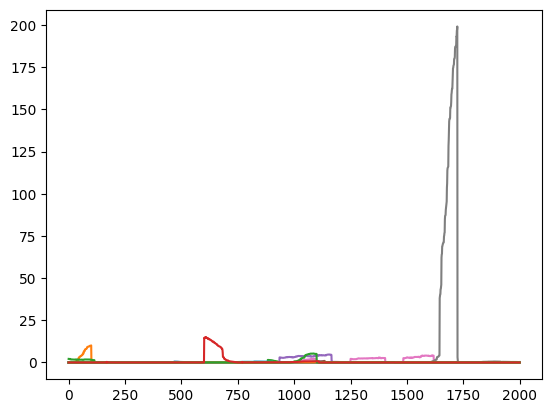

K562: 
Threshold: 0.001
Genes per Fold: 
1: 11
3: 5
4: 2
5: 5
6: 13
7: 1
8: 3
10: 11
12: 5
Total Number of Matches: 56
Total Matches with >= 1 Non-Zero Value: 26
Percentage of TSSs with No Signal: 53.57%
Genes w/ Signal: ['ENSG00000237973', 'ENSG00000229344', 'ENSG00000237491', 'ENSG00000228794_2', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000291156', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000160072', 'ENSG00000160075_1']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187608', 'ENSG00000188157', 'ENS

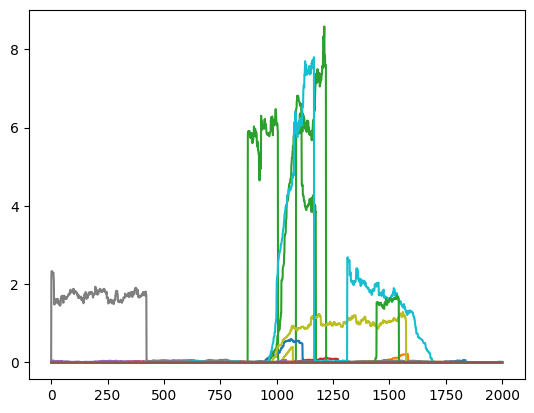

In [58]:
print("GM12878: ")
gm_low_error_signal, gm_low_error_no_signal = test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/2025-07-31/low_errors", "GM12878")

print("K562: ")
k5_low_error_signal, k5_low_error_no_signal = test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/2025-07-31/low_errors", "K562")

High Errors

In [59]:
gm["Error"].quantile([0.9, 0.95, 0.99])

0.90    0.965514
0.95    1.372450
0.99    2.260402
Name: Error, dtype: float64

In [60]:
k5["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.117580
0.95    1.563461
0.99    2.316878
Name: Error, dtype: float64

GM12878: 
Threshold: 1
Genes per Fold: 
1: 311
2: 253
3: 165
4: 129
5: 239
6: 217
7: 171
8: 255
9: 220
10: 273
11: 172
12: 240
Total Number of Matches: 2645
Total Matches with >= 1 Non-Zero Value: 2221
Percentage of TSSs with No Signal: 16.03%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000175756', 'ENSG0

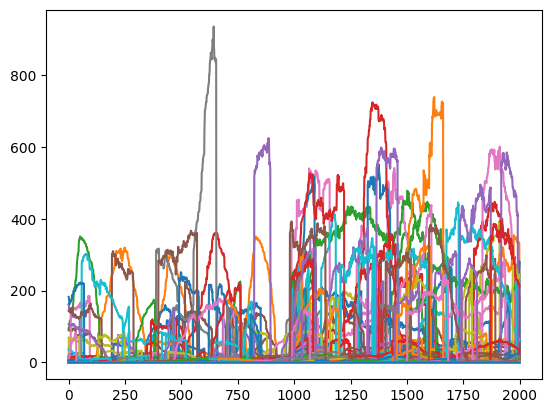

K562: 
Threshold: 1
Genes per Fold: 
1: 366
2: 319
3: 225
4: 164
5: 257
6: 256
7: 244
8: 346
9: 293
10: 383
11: 258
12: 362
Total Number of Matches: 3473
Total Matches with >= 1 Non-Zero Value: 2951
Percentage of TSSs with No Signal: 15.03%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG0000

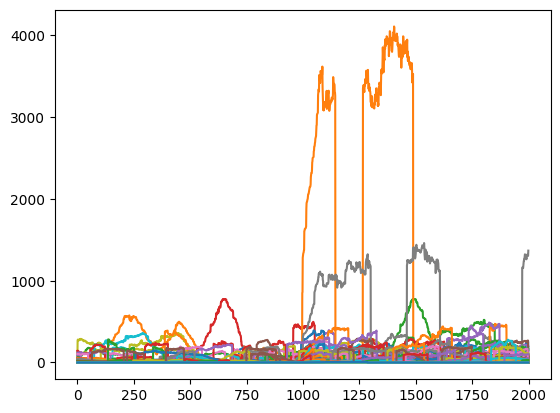

In [61]:
print("GM12878: ")
gm_high_error_signal, gm_high_error_no_signal = test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g", "predictions/2025-07-31/high_errors", "GM12878")

print("K562: ")
k5_high_error_signal, k5_high_error_no_signal = test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g", "predictions/2025-07-31/high_errors", "K562")

Overestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1018
2: 1180
3: 804
4: 649
5: 1067
6: 919
7: 939
8: 988
9: 1153
10: 1206
11: 869
12: 1357
Total Number of Matches: 12149
Total Matches with >= 1 Non-Zero Value: 8585
Percentage of TSSs with No Signal: 29.34%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000175756', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000197530', 'ENSG00000272106', '

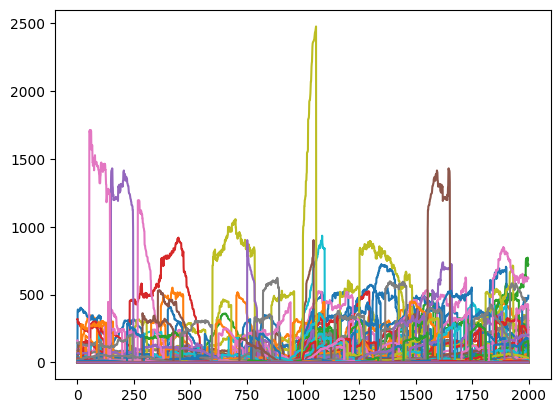

K562
Threshold: 0
Genes per Fold: 
1: 1172
2: 1159
3: 816
4: 539
5: 888
6: 785
7: 964
8: 984
9: 1089
10: 1341
11: 1193
12: 1296
Total Number of Matches: 12226
Total Matches with >= 1 Non-Zero Value: 8672
Percentage of TSSs with No Signal: 29.07%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG000

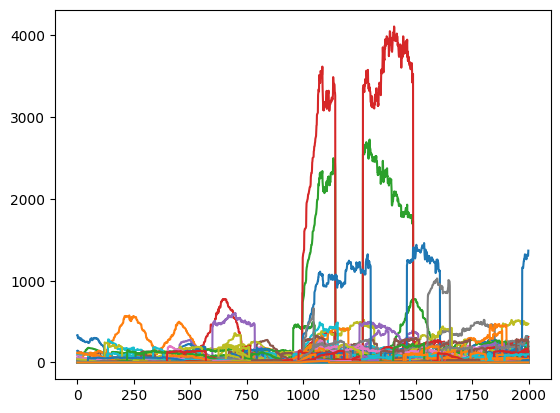

In [62]:
print("GM12878: ")
gm_over_signal, gm_over_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "l", "predictions/2025-07-31/overestimates", "GM12878")

print("K562")
k5_over_signal, k5_over_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "l", "predictions/2025-07-31/overestimates", "K562")

Underestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1768
2: 1413
3: 1133
4: 940
5: 1256
6: 1070
7: 1150
8: 1614
9: 1345
10: 1786
11: 1390
12: 1343
Total Number of Matches: 16208
Total Matches with >= 1 Non-Zero Value: 9287
Percentage of TSSs with No Signal: 42.70%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG00000189409', 'ENSG00000189339', 'ENSG00000008130', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000142609'

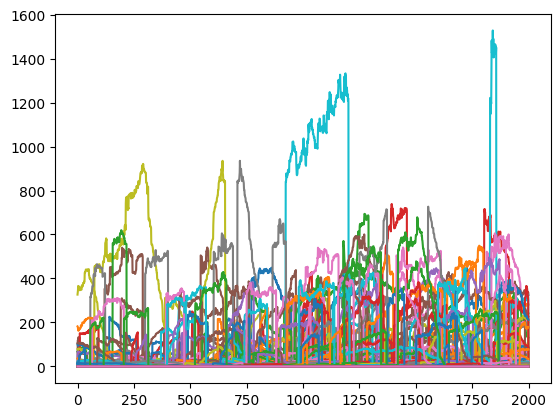

K562
Threshold: 0
Genes per Fold: 
1: 1614
2: 1434
3: 1121
4: 1050
5: 1435
6: 1204
7: 1125
8: 1618
9: 1409
10: 1651
11: 1066
12: 1404
Total Number of Matches: 16131
Total Matches with >= 1 Non-Zero Value: 9419
Percentage of TSSs with No Signal: 41.61%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000187583', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000162576', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000197530_1', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000189339', 'ENSG00000008128', 'ENSG00000078369', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000142609_1', 'ENSG00000067606_

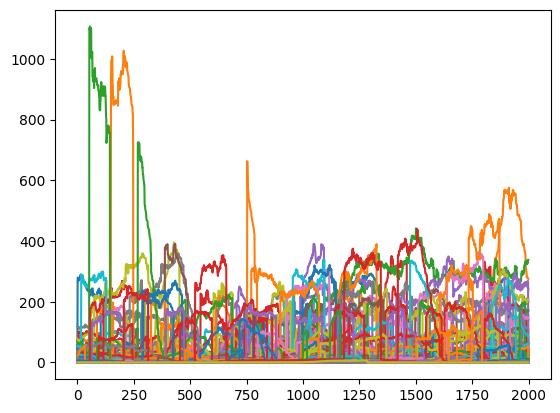

In [63]:
print("GM12878: ")
gm_under_signal, gm_under_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "g", "predictions/2025-07-31/underestimates", "GM12878")

print("K562")
k5_under_signal, k5_under_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "g", "predictions/2025-07-31/underestimates", "K562")

Worst Errors (Over Expressed)

In [64]:
n = 5

In [65]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Signed Error"] = pd.to_numeric(over_df_gm["Signed Error"])
    over_df_5_worst_gm = over_df_gm.nlargest(n, columns=["Signed Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Signed Error"] = pd.to_numeric(over_df_k5["Signed Error"])
    over_df_5_worst_k5 = over_df_k5.nlargest(n, columns=["Signed Error"])

print("GM12878: ")
display(over_df_5_worst_gm)

print("K562: ")
display(over_df_5_worst_k5)

GM12878: 


Unnamed: 0      Pred  actual  fold_idx  GM12878_CAGE_128*3_sum  \
10427  ENSG00000092199  3.815418     0.0         5                     NaN   
31     ENSG00000142676  3.319914     0.0         1                     NaN   
2686   ENSG00000126067  3.317526     0.0         1                     NaN   
900    ENSG00000143621  3.248057     0.0         1                     NaN   
1652   ENSG00000132485  3.218432     0.0         1                     NaN   

          Error  Signed Error  
10427  3.815418      3.815418  
31     3.319914      3.319914  
2686   3.317526      3.317526  
900    3.248057      3.248057  
1652   3.218432      3.218432

K562: 


Unnamed: 0      Pred  actual  fold_idx  GM12878_CAGE_128*3_sum  \
9765   ENSG00000274012  3.689557     0.0         5                 310.960   
17906  ENSG00000213593  3.400767     0.0         8                     NaN   
785    ENSG00000117748  3.267449     0.0         1                 881.266   
17061  ENSG00000074201  3.242111     0.0         8                1699.940   
8976   ENSG00000092199  3.237844     0.0         5                     NaN   

          Error  Signed Error  
9765   3.689557      3.689557  
17906  3.400767      3.400767  
785    3.267449      3.267449  
17061  3.242111      3.242111  
8976   3.237844      3.237844

GM12878: 


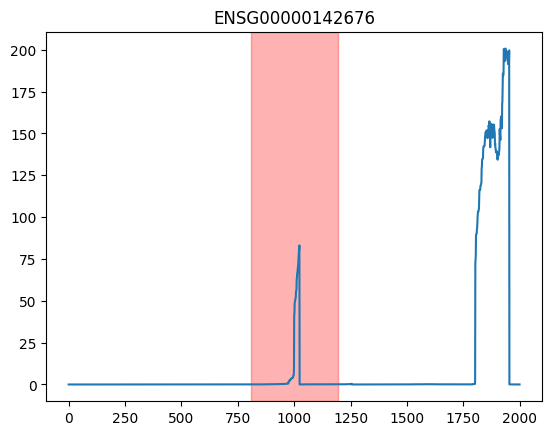

Pred: 3.3199139
Actual: 0.0


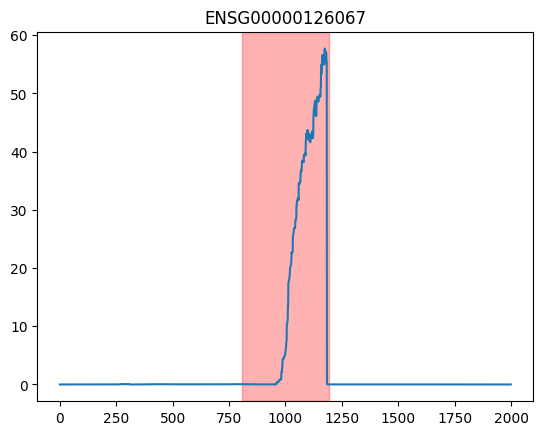

Pred: 3.3175259
Actual: 0.0


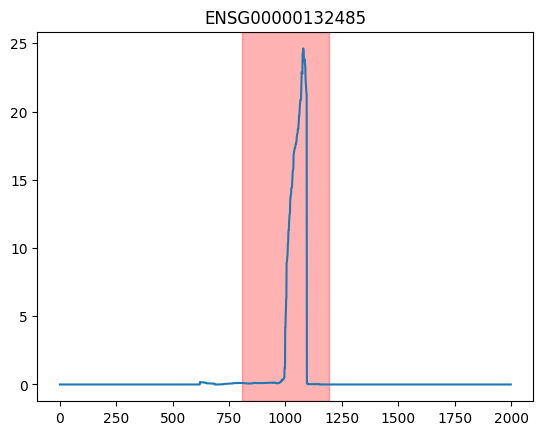

Pred: 3.2184324
Actual: 0.0


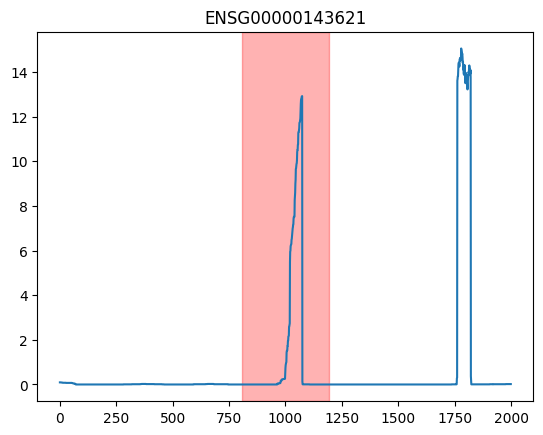

Pred: 3.248057
Actual: 0.0


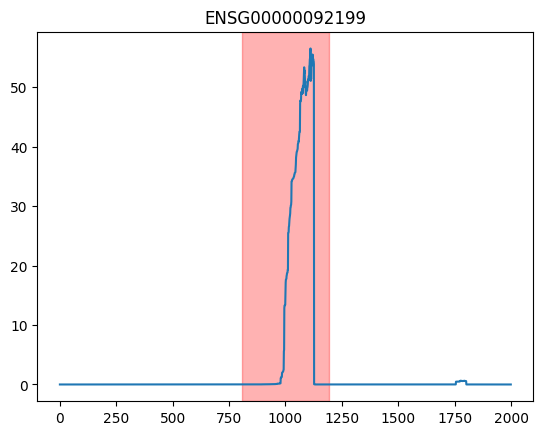

Pred: 3.8154185
Actual: 0.0

K562: 


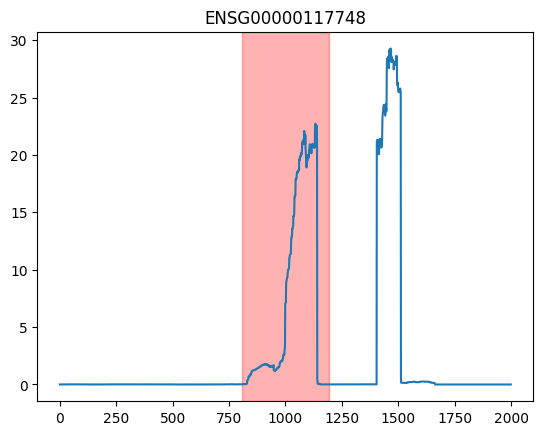

Pred: 3.2674494
Actual: 0.0


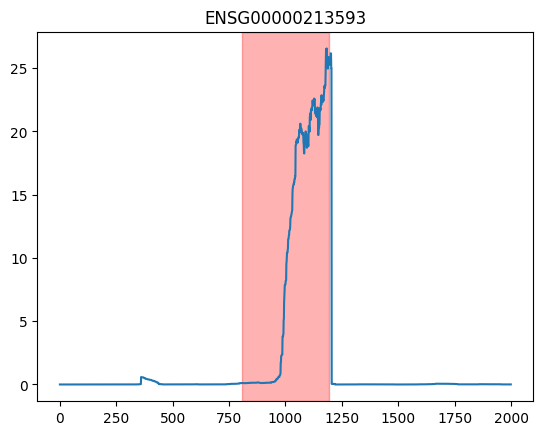

Pred: 3.4007668
Actual: 0.0


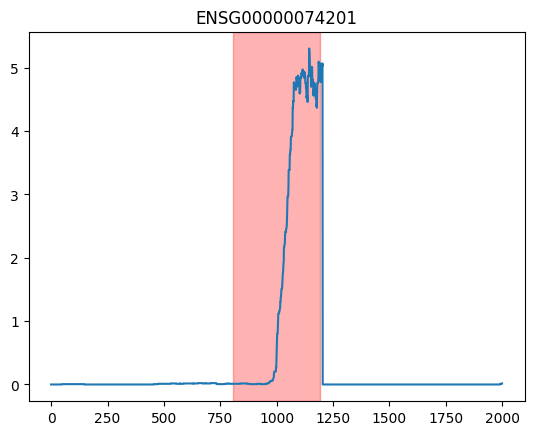

Pred: 3.242111
Actual: 0.0


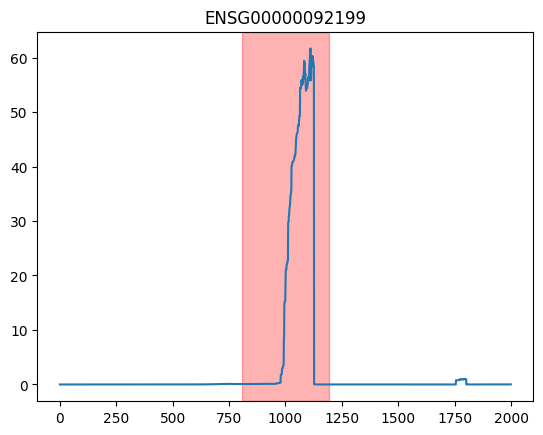

Pred: 3.237844
Actual: 0.0


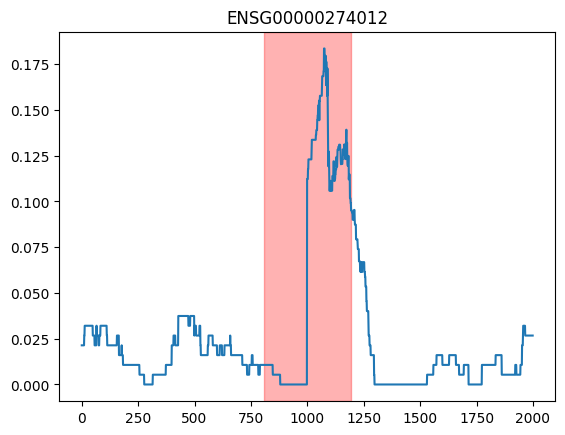

Pred: 3.6895568
Actual: 0.0


In [66]:
# Individual Plots
signal_5_worst_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_over_gm):
    plt.plot(signal_5_worst_over_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-31/overestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_over_k5):
    plt.plot(signal_5_worst_over_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-31/overestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

Worst Errors (Under Expressed)

In [67]:
with pd.option_context("mode.chained_assignment", None):
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Signed Error"] = pd.to_numeric(under_df_gm["Signed Error"])
    under_df_5_worst_gm = under_df_gm.nsmallest(n, columns=["Signed Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Signed Error"] = pd.to_numeric(under_df_k5["Signed Error"])
    under_df_5_worst_k5 = under_df_k5.nsmallest(n, columns=["Signed Error"])

print("GM12878: ")
display(under_df_5_worst_gm)

print("K562: ")
display(under_df_5_worst_k5)

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
18257  ENSG00000202538  0.773680  5.662860         9               460107.00   
23544  ENSG00000272160  0.222919  4.697162        11                49791.30   
1341   ENSG00000201317  0.331418  4.349751         1                22373.40   
513    ENSG00000143185  0.088247  3.915335         1                 8227.76   
15771  ENSG00000199325  0.381879  3.754244         8                 5677.64   

          Error  Signed Error  
18257  4.889180     -4.889180  
23544  4.474243     -4.474243  
1341   4.018334     -4.018334  
513    3.827088     -3.827088  
15771  3.372365     -3.372365

K562: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
24232  ENSG00000219932  0.079738  3.243274        11                1440.800   
15790  ENSG00000214391  0.337205  3.191269         8                1424.320   
2508   ENSG00000163554  0.119854  2.906312         1                     NaN   
12872  ENSG00000139675  0.186828  2.949458         6                1046.380   
24199  ENSG00000230507  0.099982  2.704852        11                 668.273   

          Error  Signed Error  
24232  3.163536     -3.163536  
15790  2.854065     -2.854065  
2508   2.786459     -2.786459  
12872  2.762630     -2.762630  
24199  2.604870     -2.604870

GM12878: 


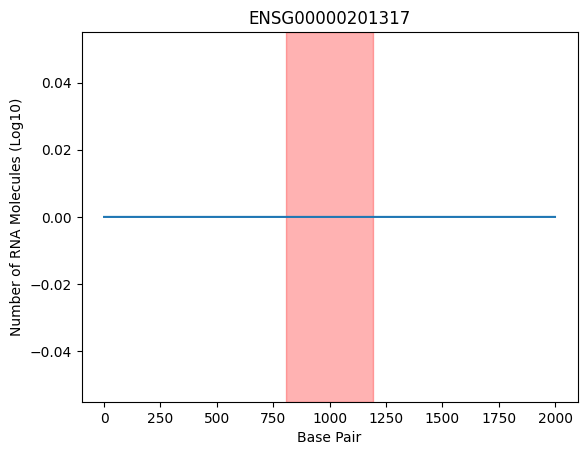

Pred: 0.33141792
Actual: 4.3497515


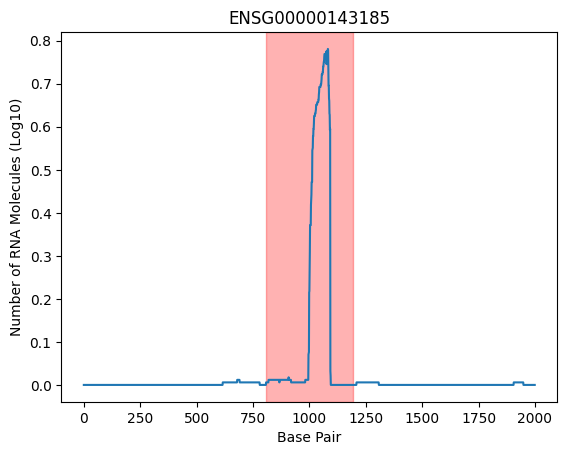

Pred: 0.088246614
Actual: 3.9153345


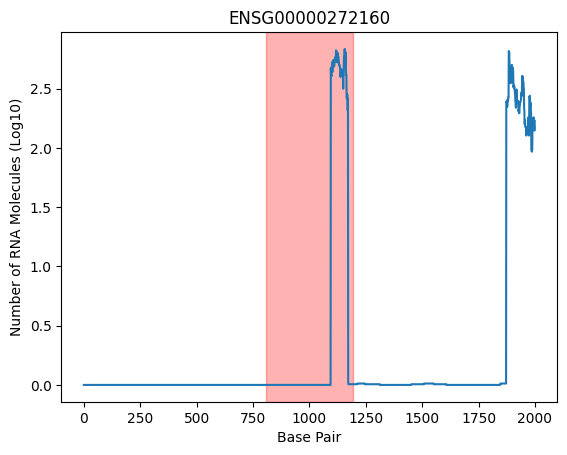

Pred: 0.22291861
Actual: 4.697162


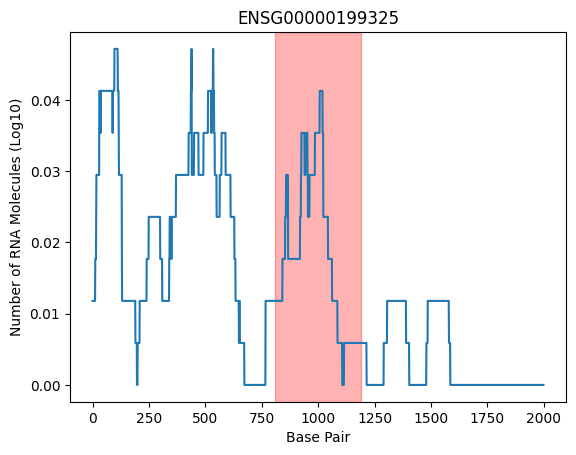

Pred: 0.38187912
Actual: 3.7542443


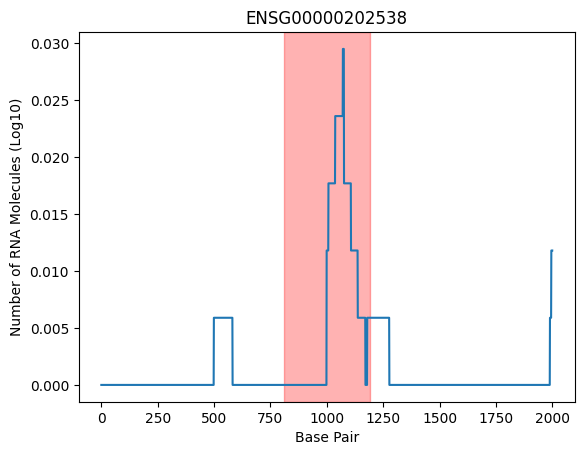

Pred: 0.77368045
Actual: 5.66286

K562: 


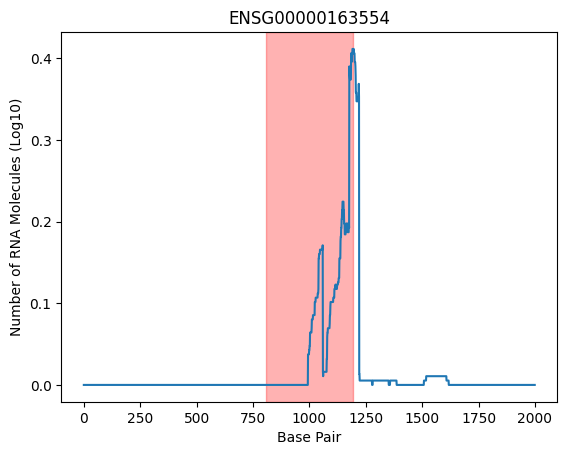

Pred: 0.11985397
Actual: 2.9063125


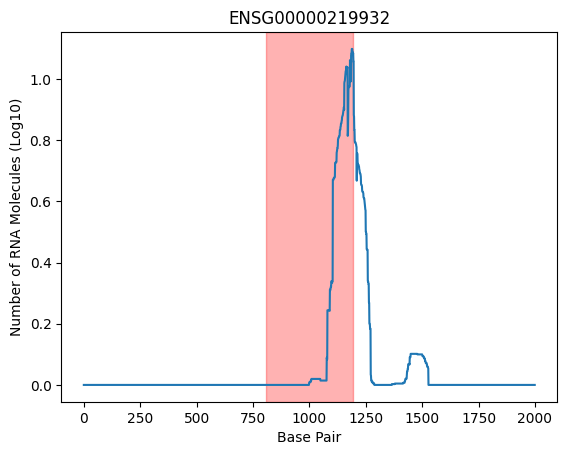

Pred: 0.07973796
Actual: 3.2432737


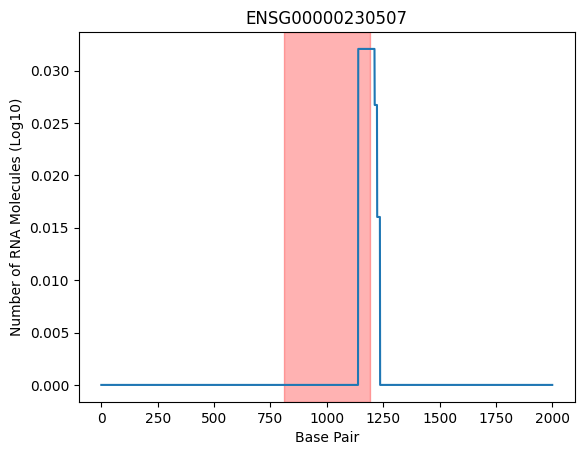

Pred: 0.099982485
Actual: 2.704852


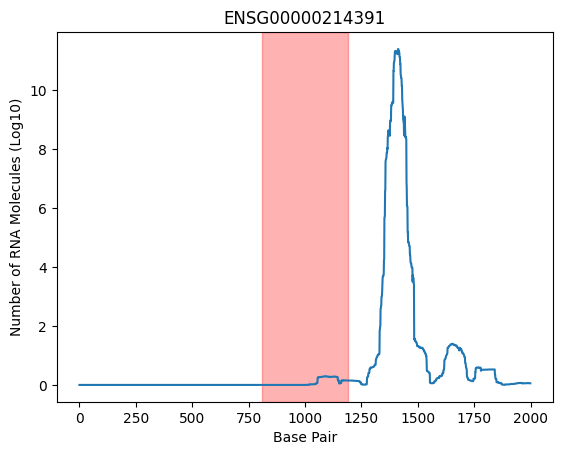

Pred: 0.33720475
Actual: 3.1912694


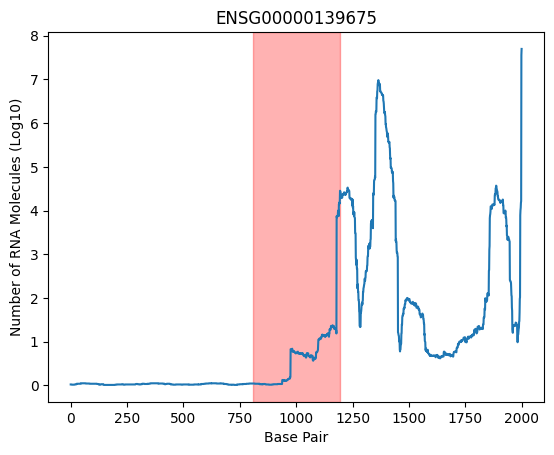

Pred: 0.18682823
Actual: 2.9494584


In [68]:
# Individual Plots
signal_5_worst_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_worst_under_gm = 10 ** signal_5_worst_under_gm - 1
# signal_5_worst_under_k5 = 10 ** signal_5_worst_under_k5 - 1

ensid_5_worst_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_worst_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-31/underestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_under_k5):
    plt.plot(signal_5_worst_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-31/underestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

Best Errors (Over Expressed)

In [69]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Error"] = pd.to_numeric(over_df_gm["Error"])
    over_df_5_best_gm = over_df_gm.nsmallest(n, columns=["Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Error"] = pd.to_numeric(over_df_k5["Error"])
    over_df_5_best_k5 = over_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(over_df_5_best_gm)

print("K562: ")
display(over_df_5_best_k5)

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
19639    ENSG00000011105  1.655105  1.655129         9   
10086    ENSG00000092096  1.448889  1.448830         5   
525      ENSG00000158710  1.049550  1.049420         1   
836      ENSG00000218510  2.104455  2.104620         1   
2600   ENSG00000082512_1  2.314422  2.314602         1   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
19639                 44.1990  0.000024     -0.000024  
10086                 27.1080  0.000059      0.000059  
525                   10.2052  0.000130      0.000130  
836                  126.2390  0.000166     -0.000166  
2600                 205.3490  0.000180     -0.000180

K562: 


Unnamed: 0      Pred    actual  fold_idx  \
17329    ENSG00000200197  0.000011  0.000000         8   
281      ENSG00000081019  2.414091  2.414079         1   
1546   ENSG00000064703_2  2.450372  2.450423         1   
2366     ENSG00000173627 -0.000176  0.000000         1   
26161    ENSG00000178852  2.072230  2.072415        12   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
17329                 53.4226  0.000011      0.000011  
281                  318.6800  0.000012      0.000012  
1546                 344.2520  0.000051     -0.000051  
2366                      NaN  0.000176     -0.000176  
26161                112.1540  0.000185     -0.000185

GM12878: 


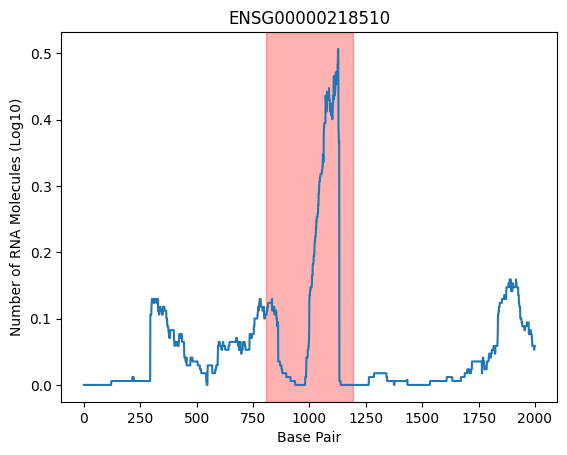

Pred: 2.1044545
Actual: 2.1046202


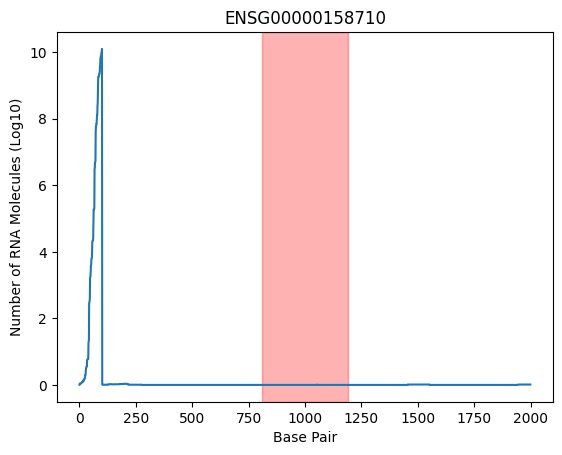

Pred: 1.0495499
Actual: 1.0494196


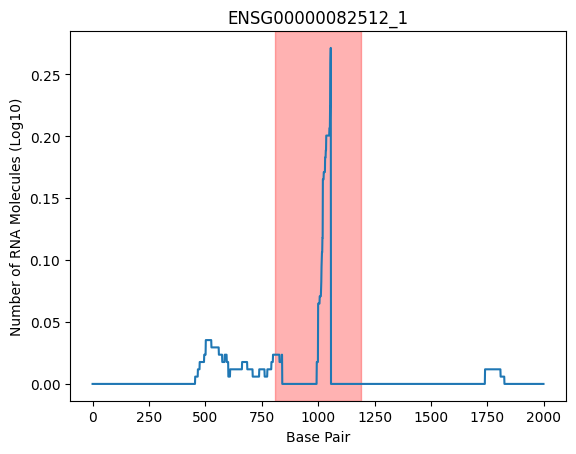

Pred: 2.314422
Actual: 2.3146024


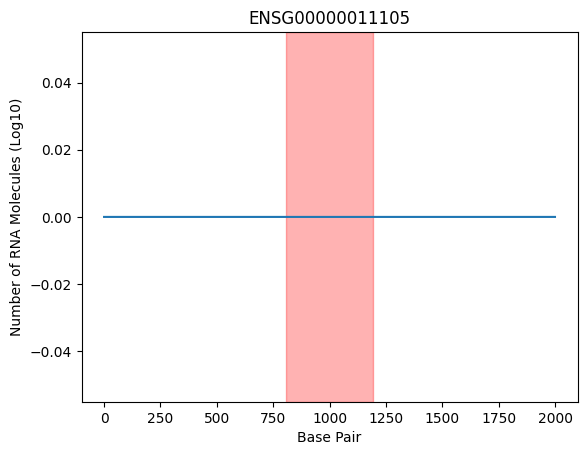

Pred: 1.6551052
Actual: 1.6551288


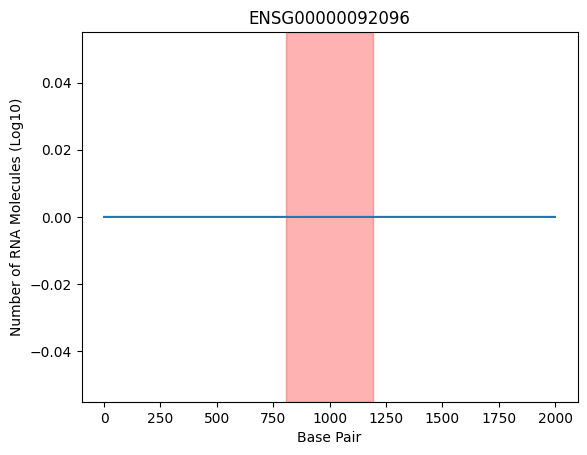

Pred: 1.4488887
Actual: 1.4488299

K562: 


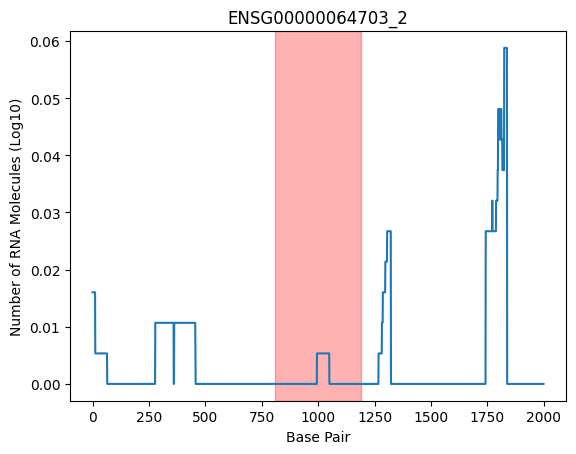

Pred: 2.4503722
Actual: 2.450423


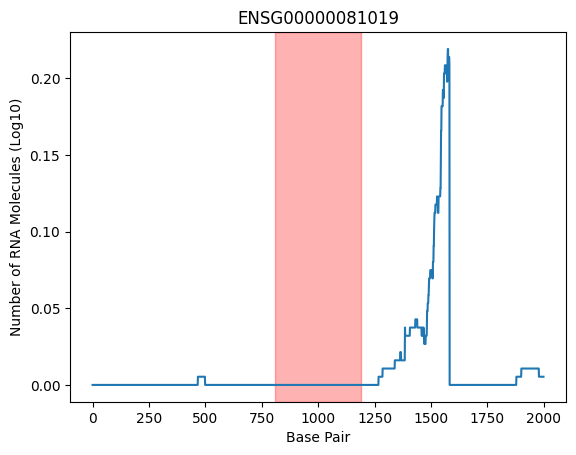

Pred: 2.414091
Actual: 2.4140787


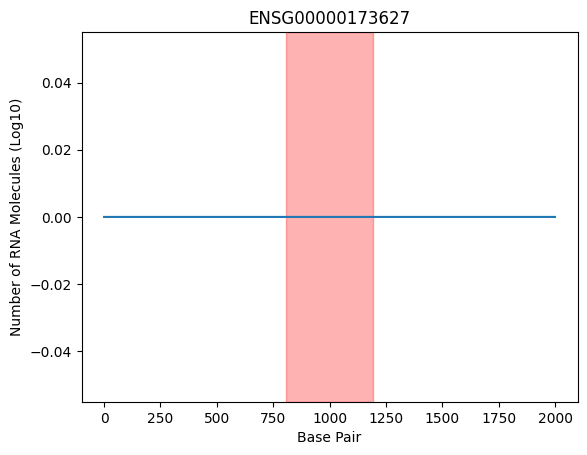

Pred: -0.00017559528
Actual: 0.0


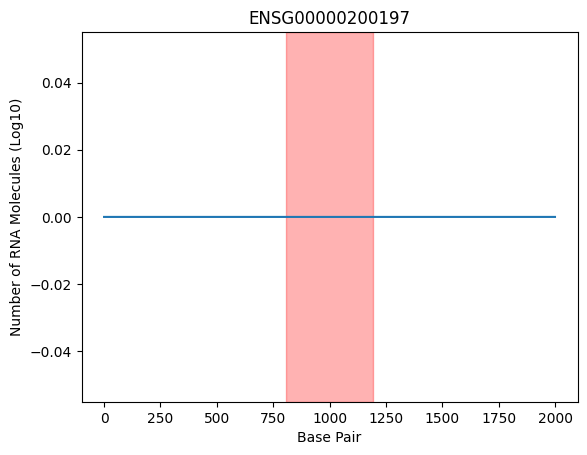

Pred: 1.052767e-05
Actual: 0.0


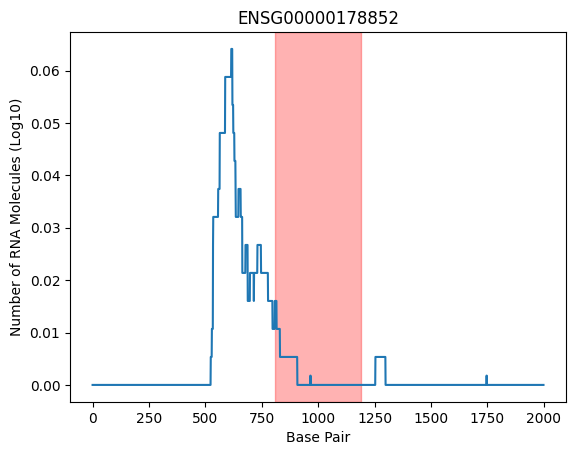

Pred: 2.07223
Actual: 2.0724154


In [70]:
# Individual Plots
signal_5_best_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_over_gm):
    plt.plot(signal_5_best_over_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-31/overestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_over_k5):
    plt.plot(signal_5_best_over_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-31/overestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

Best Errors (Under Expressed)

In [71]:
with pd.option_context("mode.chained_assignment", None): 
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Error"] = pd.to_numeric(under_df_gm["Error"])
    under_df_5_best_gm = under_df_gm.nsmallest(n, columns=["Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Error"] = pd.to_numeric(under_df_k5["Error"])
    under_df_5_best_k5 = under_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(under_df_5_best_gm)

print("K562: ")
display(under_df_5_best_k5) 

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
19639    ENSG00000011105  1.655105  1.655129         9   
10086    ENSG00000092096  1.448889  1.448830         5   
525      ENSG00000158710  1.049550  1.049420         1   
836      ENSG00000218510  2.104455  2.104620         1   
27342  ENSG00000179314_1  1.541020  1.541192        12   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
19639                 44.1990  0.000024     -0.000024  
10086                 27.1080  0.000059      0.000059  
525                   10.2052  0.000130      0.000130  
836                  126.2390  0.000166     -0.000166  
27342                 33.7690  0.000172     -0.000172

K562: 


Unnamed: 0      Pred    actual  fold_idx  \
17329    ENSG00000200197  0.000011  0.000000         8   
1546   ENSG00000064703_2  2.450372  2.450423         1   
12470  ENSG00000133083_1  1.697897  1.698388         6   
28136    ENSG00000175711  1.953839  1.954339        12   
23263  ENSG00000142002_2  2.528968  2.529536        10   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
17329                 53.4226  0.000011      0.000011  
1546                 344.2520  0.000051     -0.000051  
12470                 44.5300  0.000490     -0.000490  
28136                111.0730  0.000500     -0.000500  
23263                631.4580  0.000568     -0.000568

GM12878: 


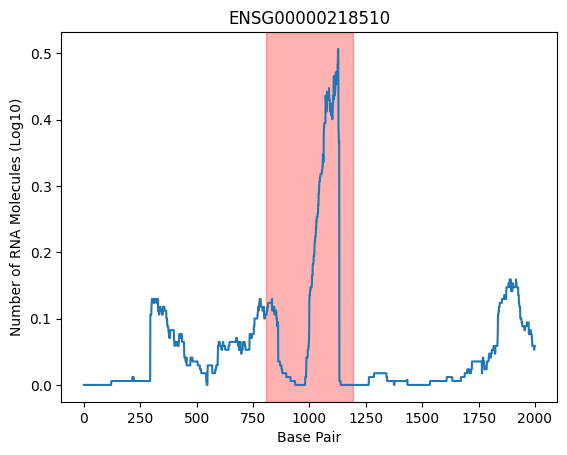

Pred: 2.1044545
Actual: 2.1046202


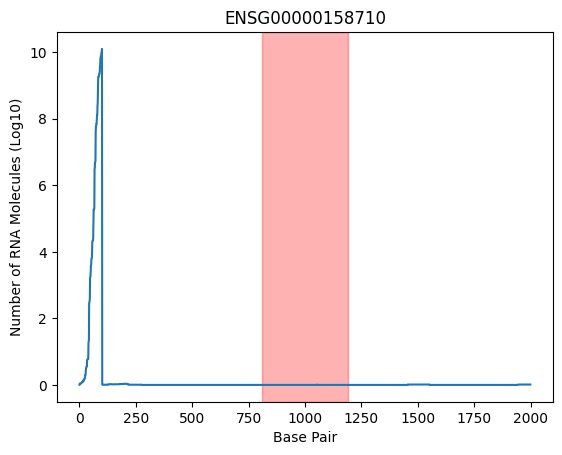

Pred: 1.0495499
Actual: 1.0494196


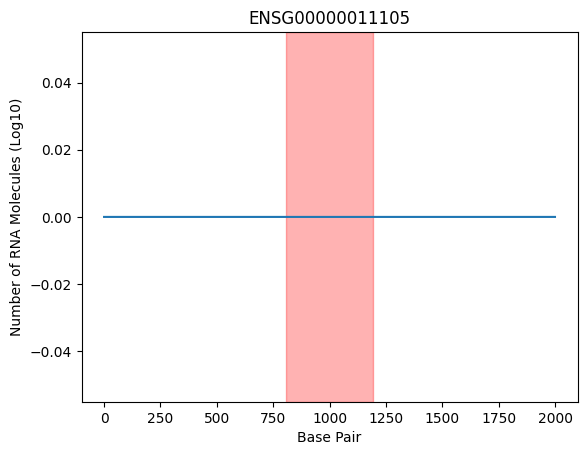

Pred: 1.6551052
Actual: 1.6551288


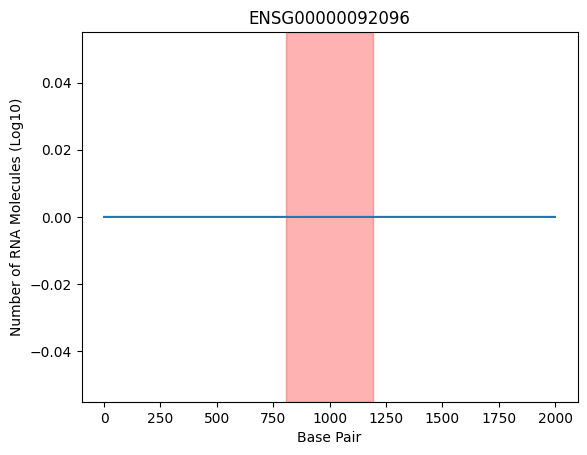

Pred: 1.4488887
Actual: 1.4488299


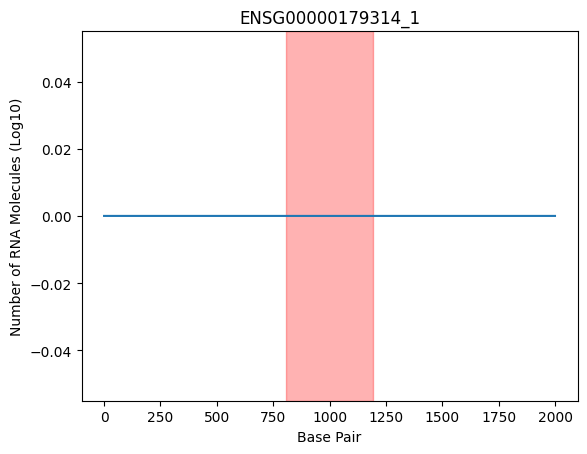

Pred: 1.5410203
Actual: 1.5411922

K562: 


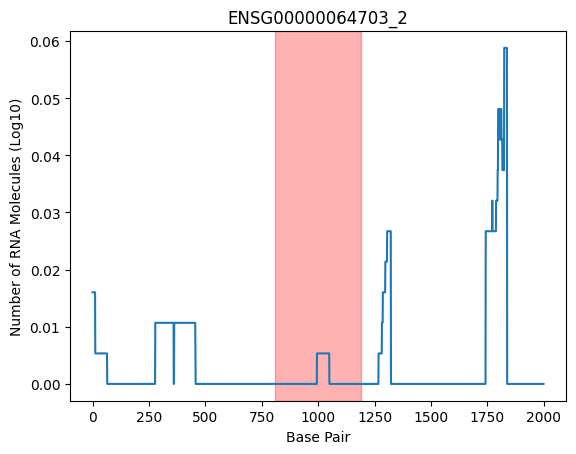

Pred: 2.4503722
Actual: 2.450423


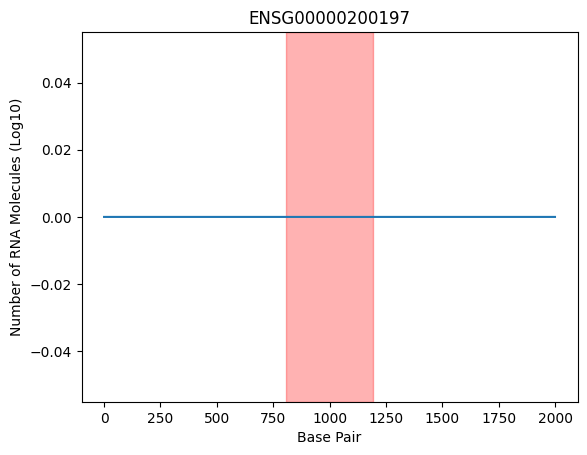

Pred: 1.052767e-05
Actual: 0.0


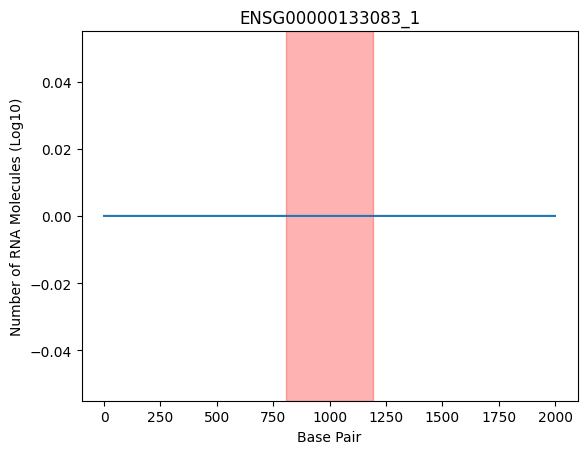

Pred: 1.6978971
Actual: 1.6983876


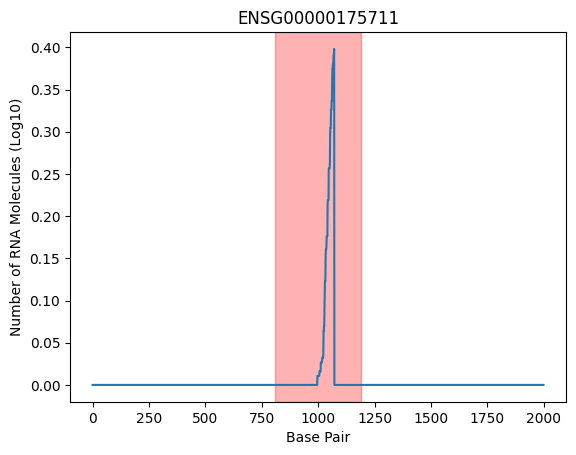

Pred: 1.9538387
Actual: 1.954339


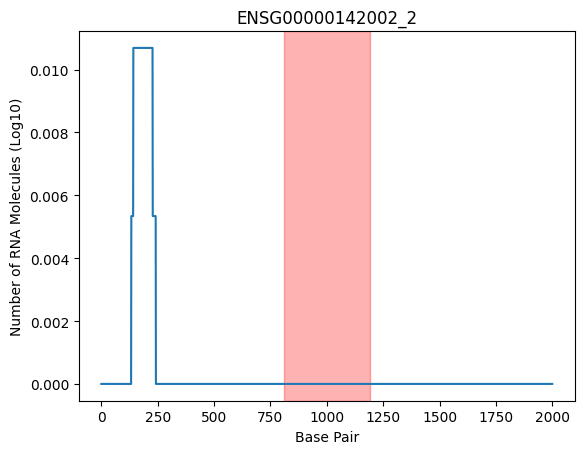

Pred: 2.528968
Actual: 2.5295355


In [72]:
# Individual Plots
signal_5_best_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_best_under_gm = 10 ** signal_5_best_under_gm - 1
# signal_5_best_under_k5 = 10 ** signal_5_best_under_k5 - 1

ensid_5_best_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_best_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-31/underestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_under_k5):
    plt.plot(signal_5_best_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-31/underestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

Zero Signal (Actual)

GM12878: 
Threshold: 0
Genes per Fold: 
1: 981
2: 822
3: 710
4: 617
5: 783
6: 649
7: 652
8: 815
9: 805
10: 909
11: 618
12: 719
Total Number of Matches: 9080
Total Matches with >= 1 Non-Zero Value: 4129
Percentage of TSSs with No Signal: 54.53%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000198744', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000187961', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000187730', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG00000197921', 'ENSG00000157873_1', 'ENSG00000157873_2', 'ENSG00000238164', 'ENSG00000130762', 

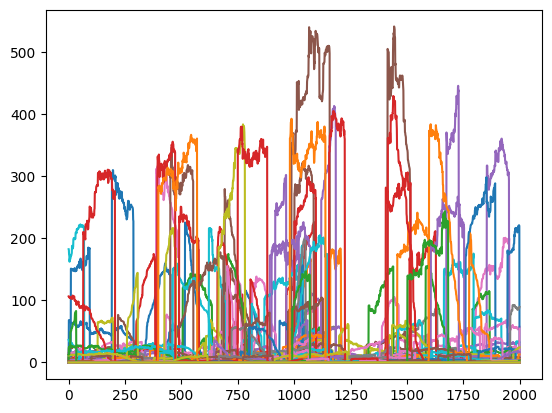

K562: 
Threshold: 0
Genes per Fold: 
1: 1253
2: 1155
3: 928
4: 772
5: 1085
6: 846
7: 862
8: 1108
9: 1116
10: 1237
11: 843
12: 1040
Total Number of Matches: 12245
Total Matches with >= 1 Non-Zero Value: 6246
Percentage of TSSs with No Signal: 48.99%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187961', 'ENSG00000188157', 'ENSG00000131591', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000175756', 'ENSG00000179403', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000197530', 'ENSG00000272106', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000142609_1', 'ENSG00000187730', 'ENSG00000067606_1', 'ENSG00000067606_2', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG0000015

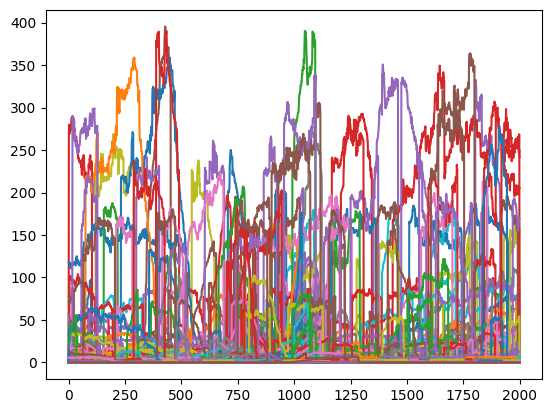

In [73]:
print("GM12878: ")
gm_no_signal_actual = test_thresholds(gm, gm_h5, "actual", [0], "eq", "predictions/2025-07-31/zero", "GM12878")

print("K562: ")
k5_no_signal_actual = test_thresholds(k5, k5_h5, "actual", [0], "eq", "predictions/2025-07-31/zero", "K562")

Aggregate FP, FN, TP, TN

In [74]:
# GM12878
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    preds = [actuals[idx] if gm["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in gm["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": gm["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "Pred": [gm["actual"].iloc[idx] > best_threshold if gm["Error"].iloc[idx] < 1.5 else 1 - (gm["actual"].iloc[idx] > best_threshold) for idx, pred in gm["Pred"].items()],
    "fold_idx": gm["fold_idx"]
}
gm_binary = pd.DataFrame(pred_actual) 

# K562
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in k5["actual"]]
    preds = [actuals[idx] if k5["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in k5["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": k5["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in k5["actual"]],
    "Pred": [k5["actual"].iloc[idx] > best_threshold if k5["Error"].iloc[idx] < 1.5 else 1 - (k5["actual"].iloc[idx] > best_threshold) for idx, pred in k5["Pred"].items()],
    "fold_idx": k5["fold_idx"]
}
k5_binary = pd.DataFrame(pred_actual) 


Best Threshold: 0.0 w/ 0.9703273954047077 F1 Score
Best Threshold: 0.0 w/ 0.9530042004017776 F1 Score


In [75]:
# GM12878
fp_gm = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 0)]
fn_gm = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 1)]
tp_gm = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 1)]
tn_gm = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 0)]

In [76]:
# GM12878
a = [fp_gm, fn_gm, tp_gm, tn_gm]
for b in a:
    print(len(b))

867
294
18983
8213


In [77]:
# GM12878
dfs = {"False Positive": fp_gm, 
       "False Negative": fn_gm, 
       "True Positive": tp_gm, 
       "True Negative": tn_gm}
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in gm_h5["ensid"]]
    rna = gm_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
    plt.savefig(f"predictions/2025-07-31/aggregate_confusion/gm_{title}.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [78]:
# K562
fp_k5 = k5_binary[(k5_binary["Pred"] == 1) & (k5_binary["actual"] == 0)]
fn_k5 = k5_binary[(k5_binary["Pred"] == 0) & (k5_binary["actual"] == 1)]
tp_k5 = k5_binary[(k5_binary["Pred"] == 1) & (k5_binary["actual"] == 1)]
tn_k5 = k5_binary[(k5_binary["Pred"] == 0) & (k5_binary["actual"] == 0)]

In [79]:
# K562
a = [fp_k5, fn_k5, tp_k5, tn_k5]
for b in a:
    print(len(b))

1087
457
15655
11158


In [80]:
# K562
dfs = {"False Positive": fp_k5, 
       "False Negative": fn_k5, 
       "True Positive": tp_k5, 
       "True Negative": tn_k5}
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in k5_h5["ensid"]]
    rna = k5_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
#     plt.show()
    plt.savefig(f"predictions/2025-07-31/aggregate_confusion/k5_{title}.png")
    plt.clf()



<Figure size 640x480 with 0 Axes>

Find genes with strong peaks in false positives

Threshold: 0.0
Number of Genes w/ Strong Peaks: 435


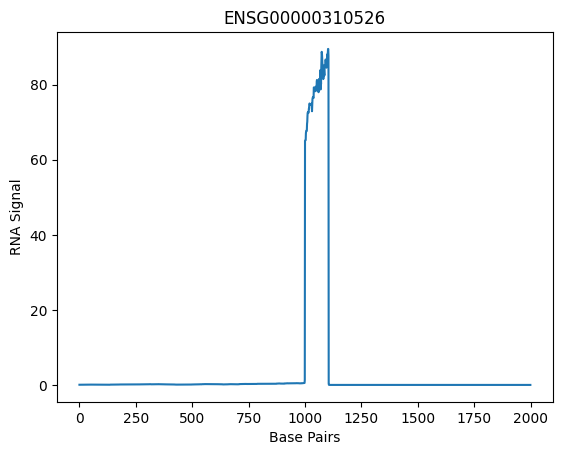

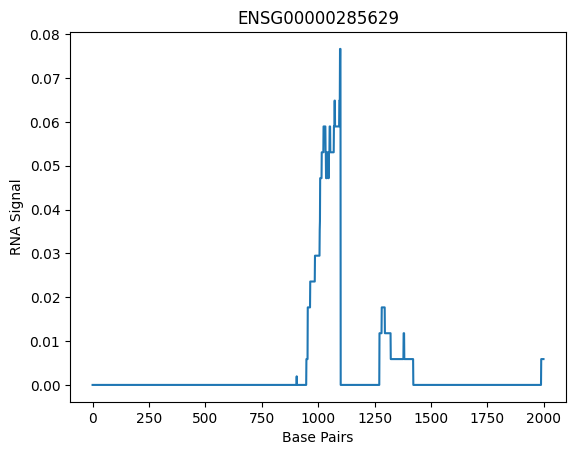

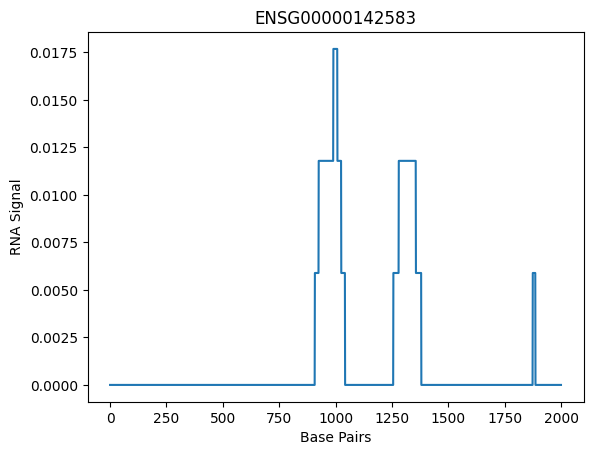

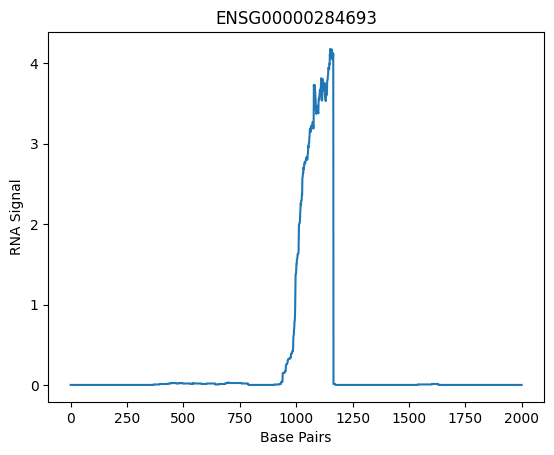

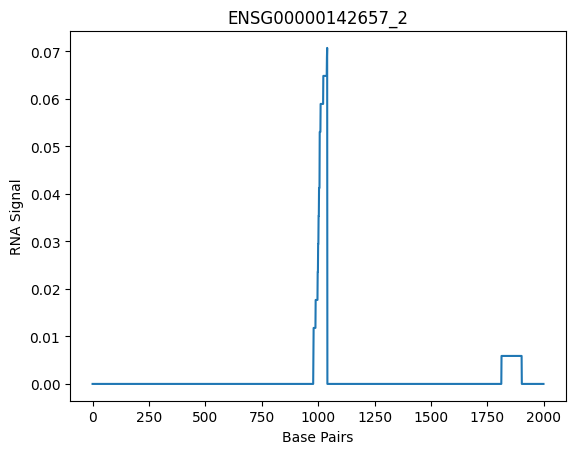

Threshold: 0.5
Number of Genes w/ Strong Peaks: 260


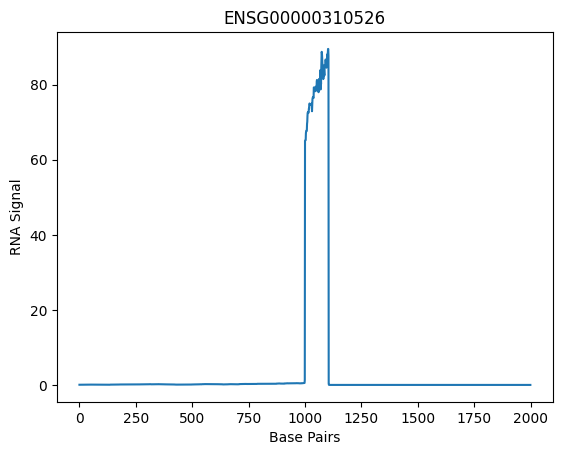

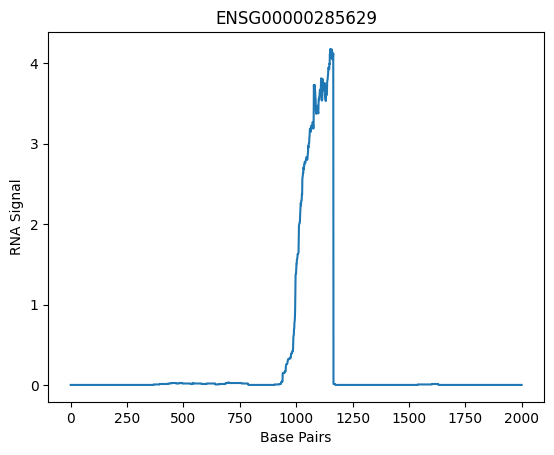

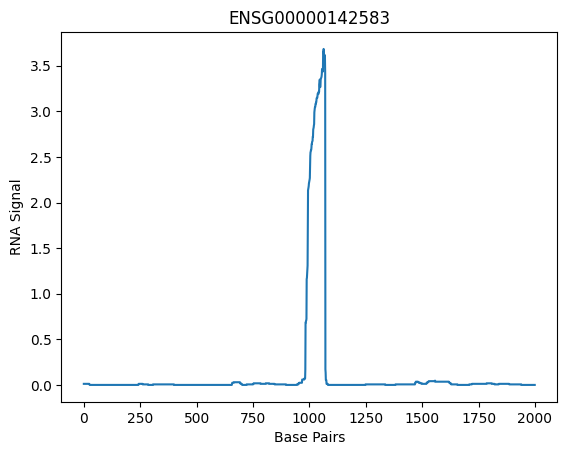

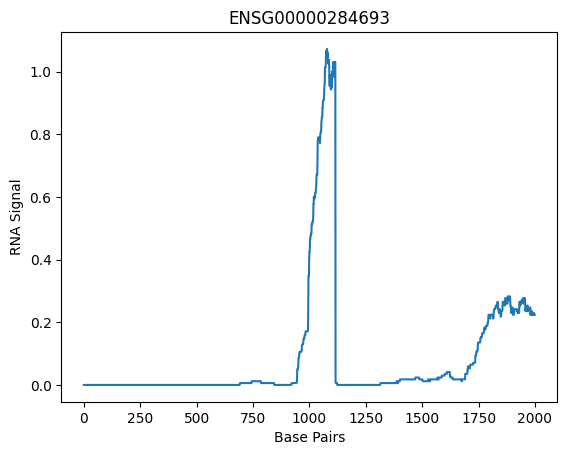

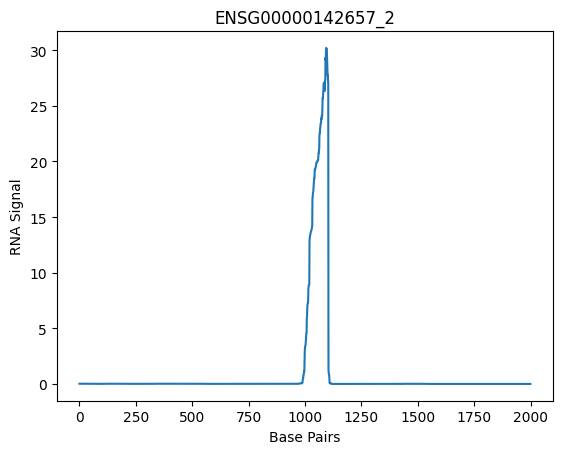

Threshold: 1.0
Number of Genes w/ Strong Peaks: 206


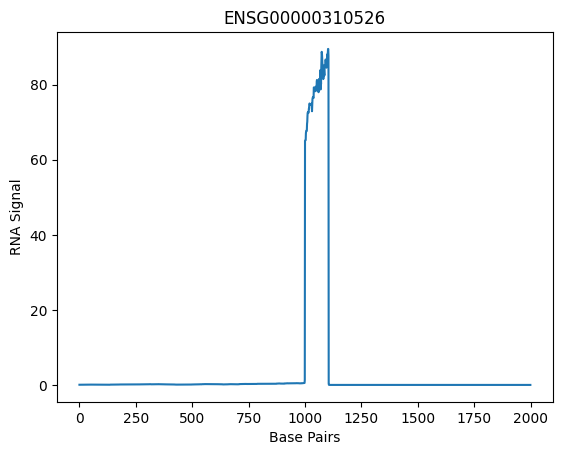

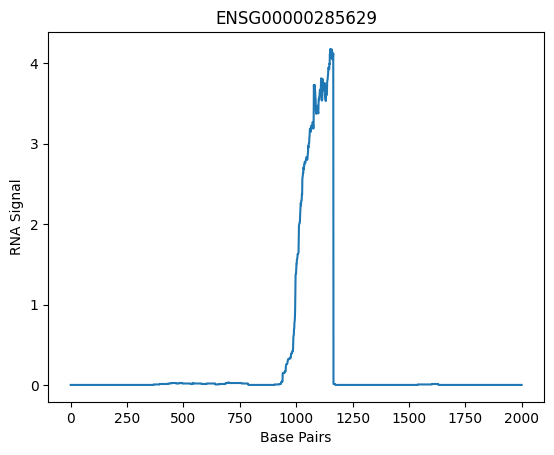

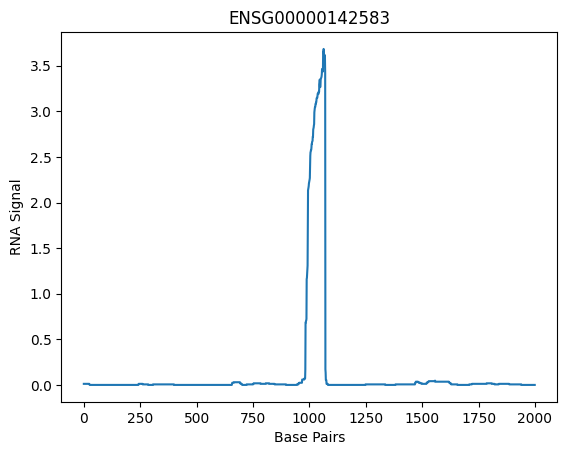

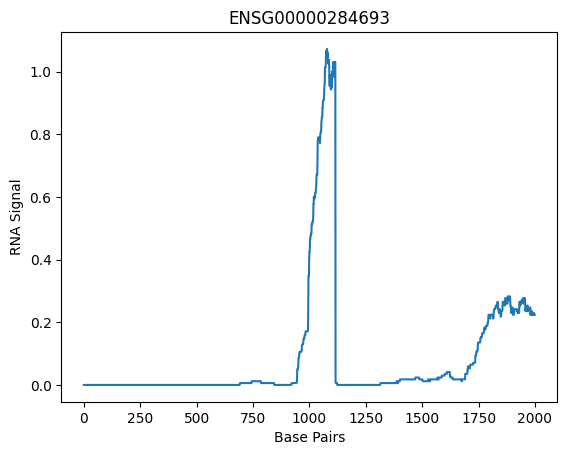

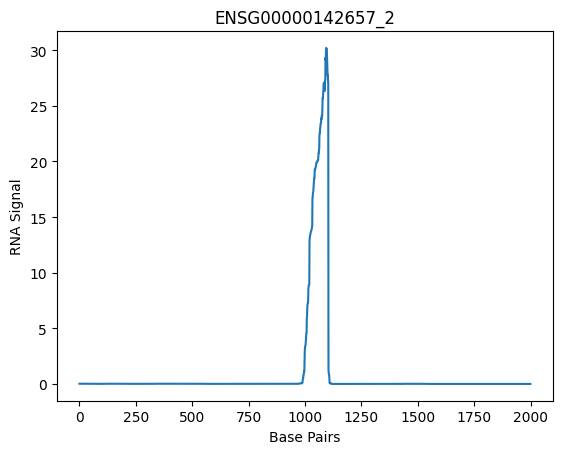

Threshold: 1.5
Number of Genes w/ Strong Peaks: 172


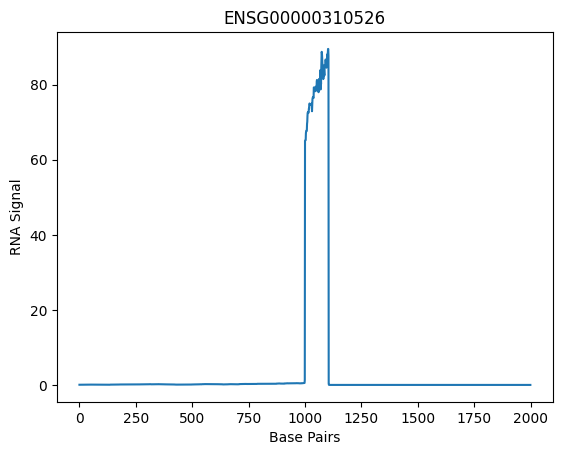

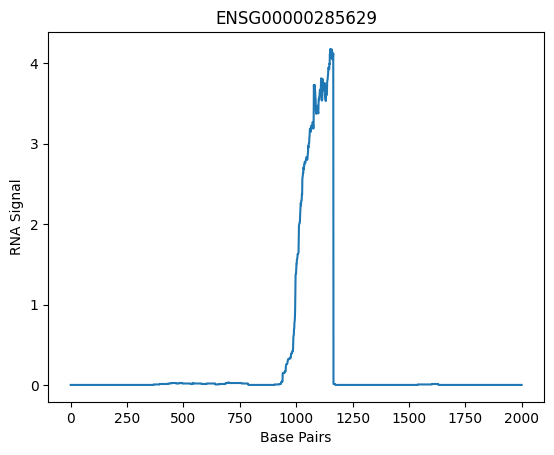

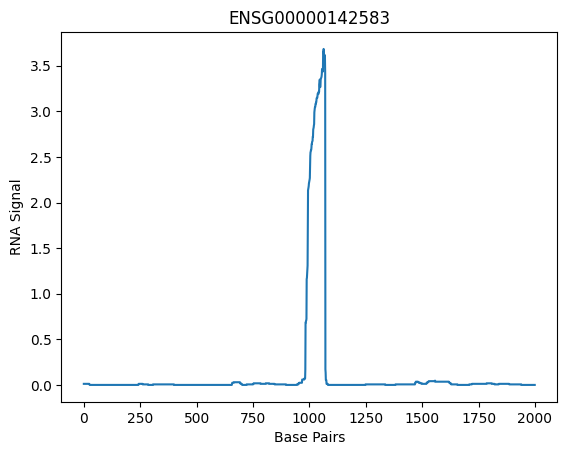

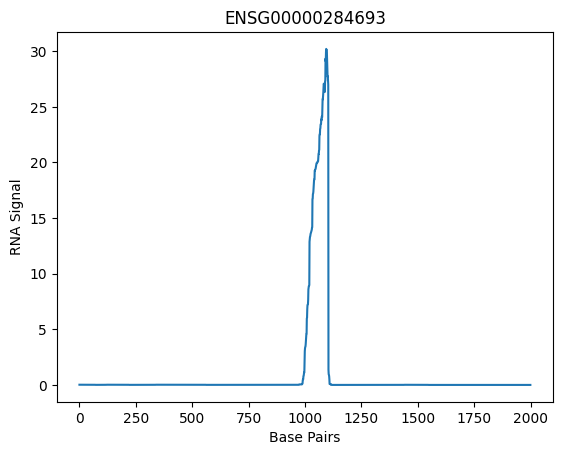

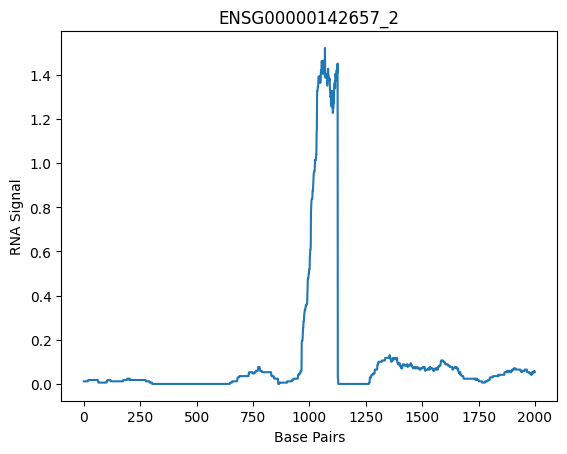

Threshold: 2.0
Number of Genes w/ Strong Peaks: 154


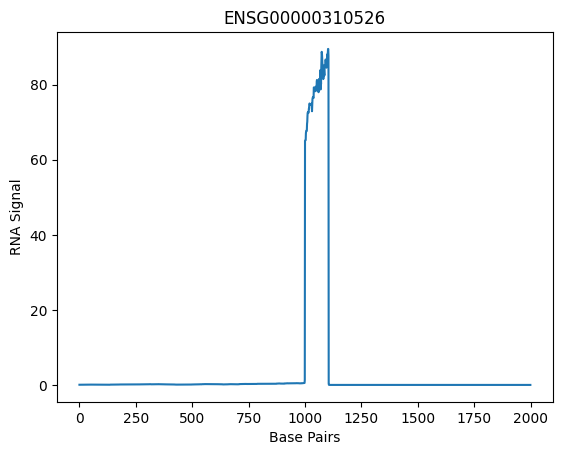

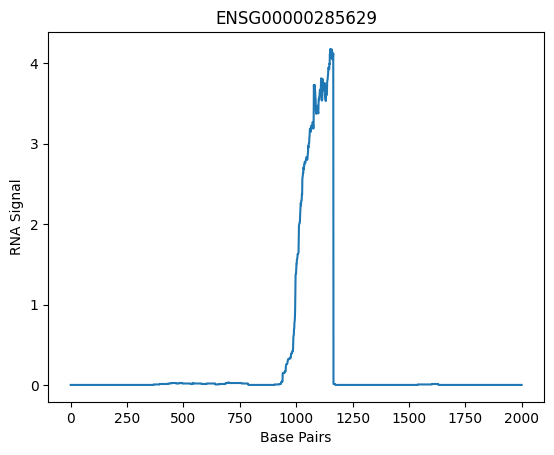

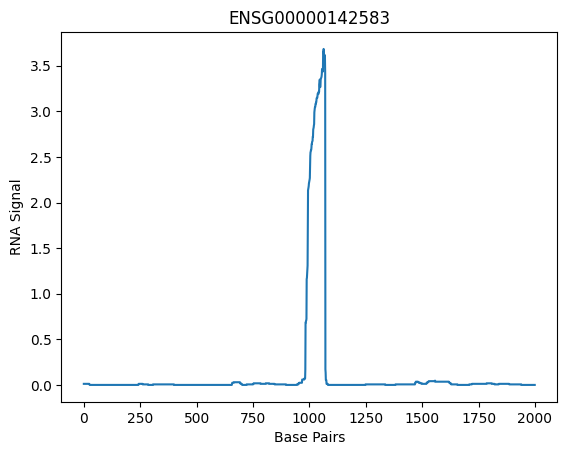

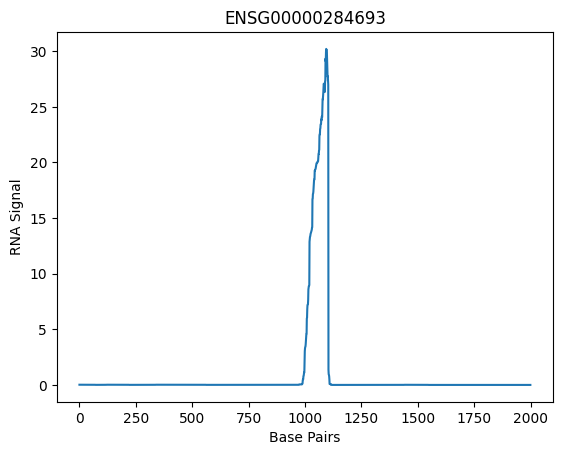

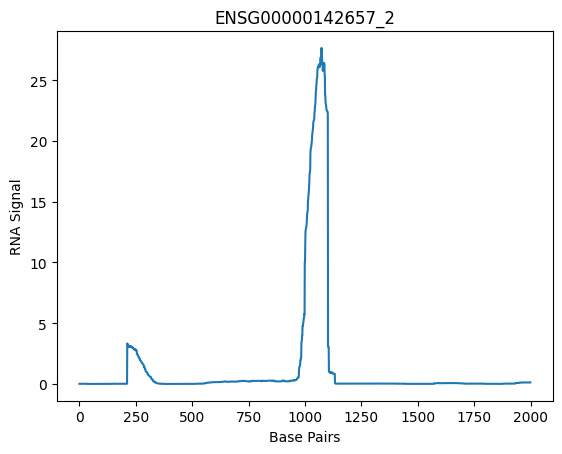

Threshold: 2.5
Number of Genes w/ Strong Peaks: 141


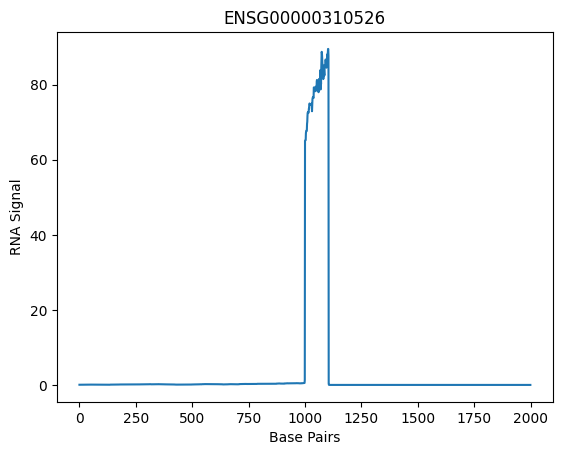

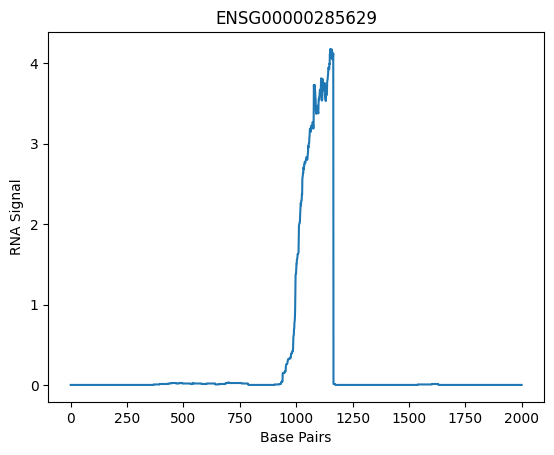

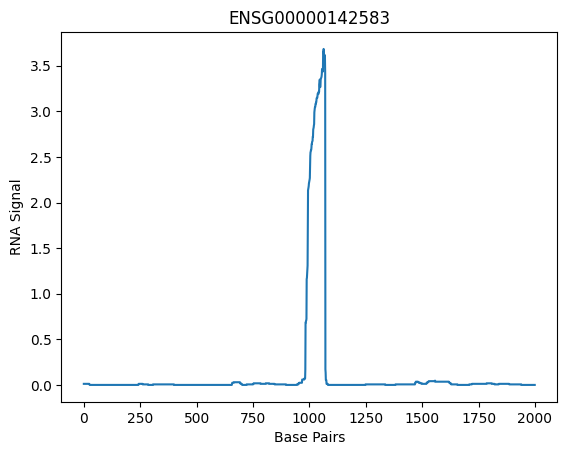

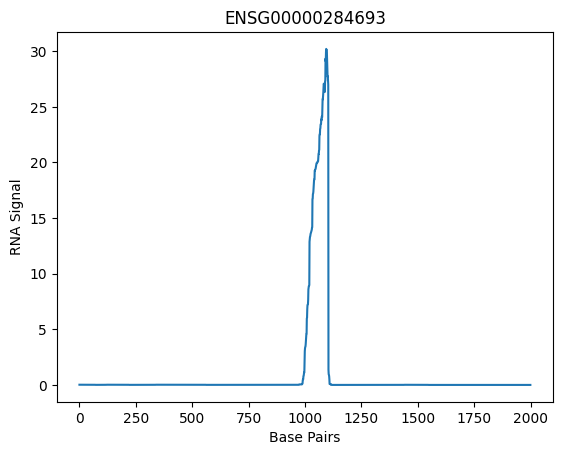

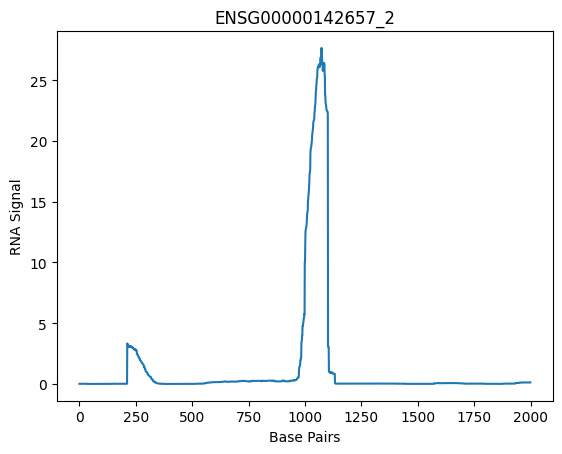

Threshold: 3.0
Number of Genes w/ Strong Peaks: 127


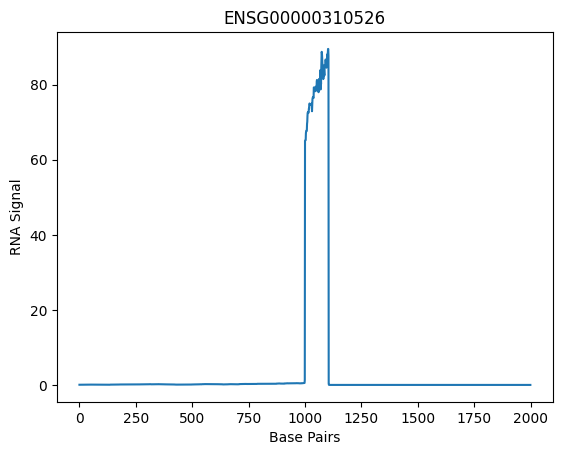

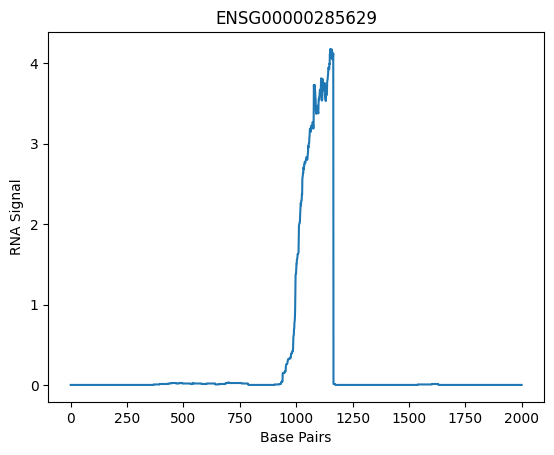

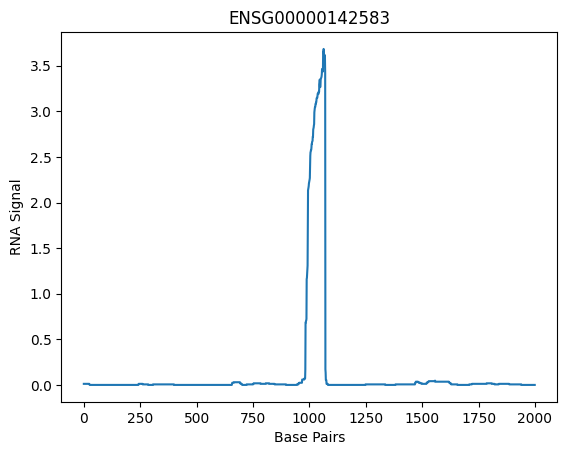

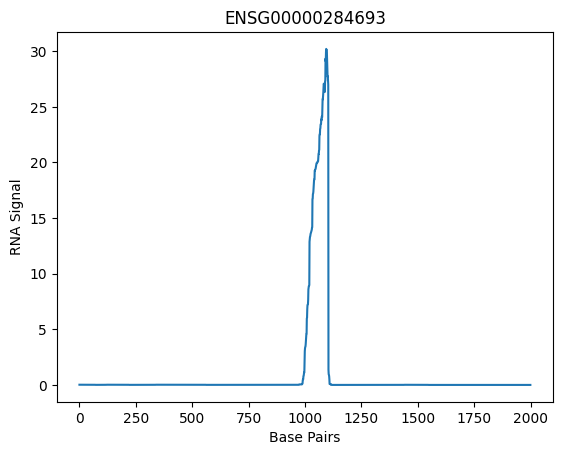

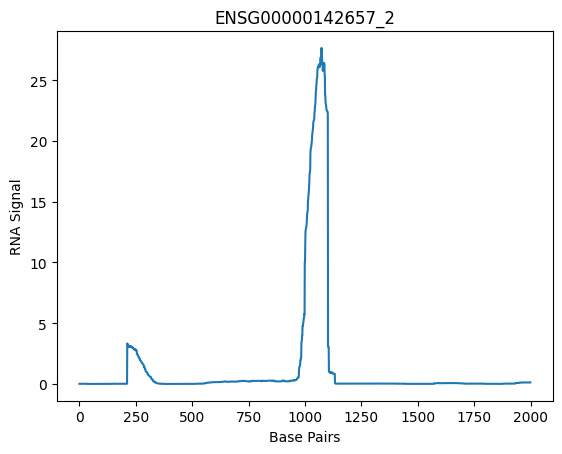

Threshold: 3.5
Number of Genes w/ Strong Peaks: 117


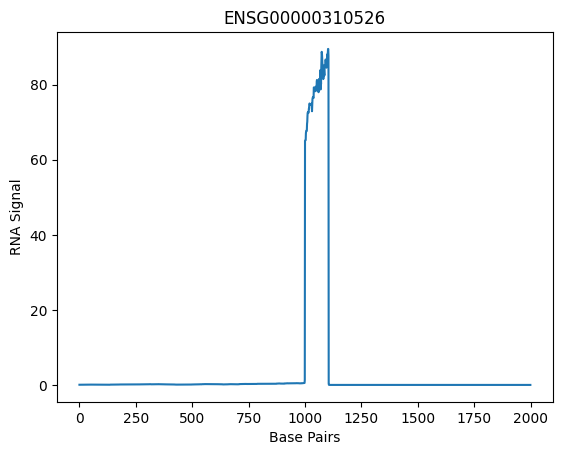

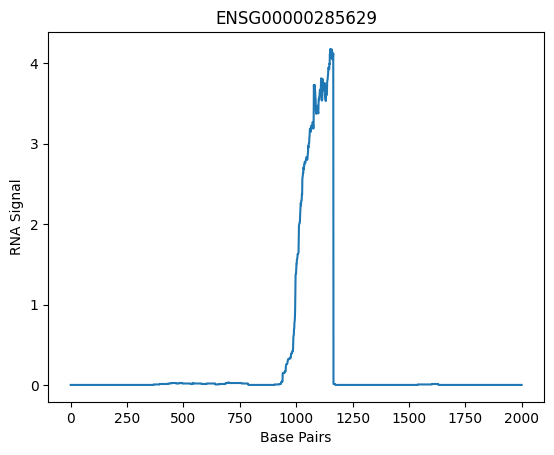

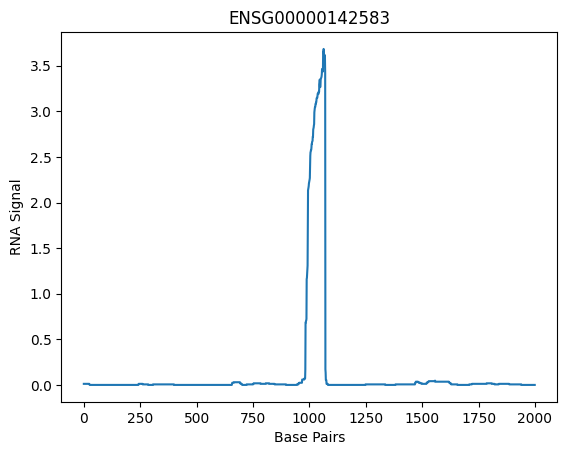

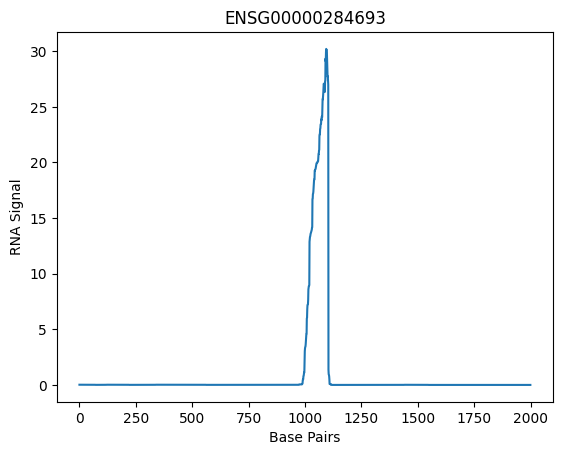

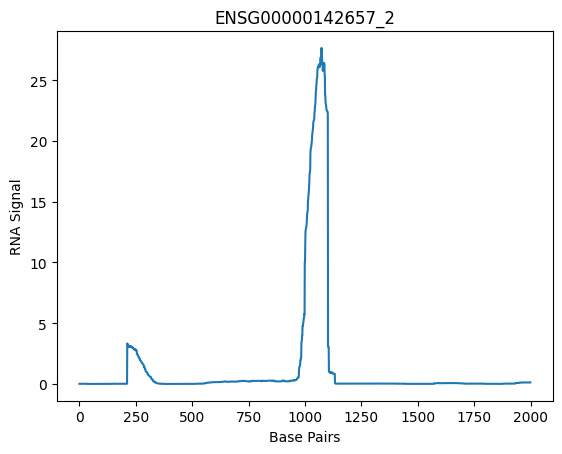

Threshold: 4.0
Number of Genes w/ Strong Peaks: 107


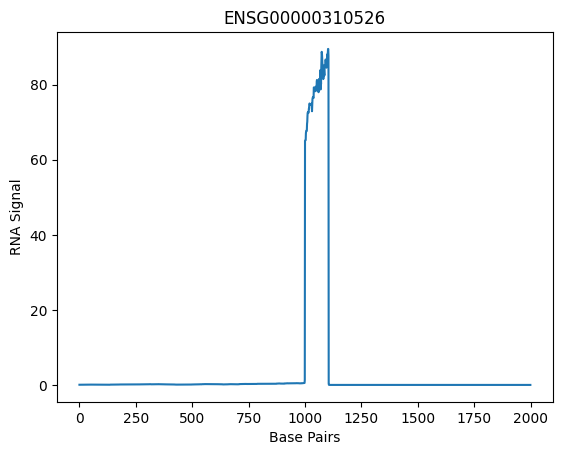

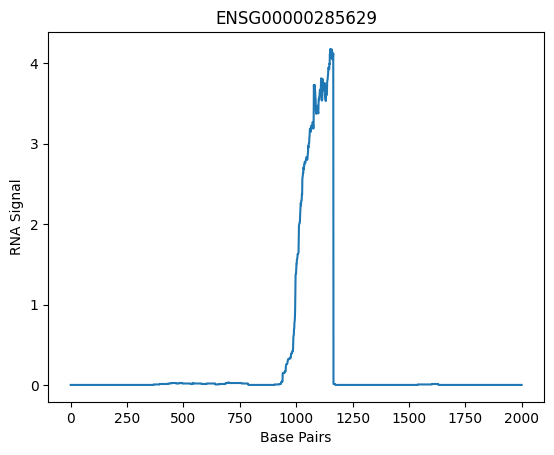

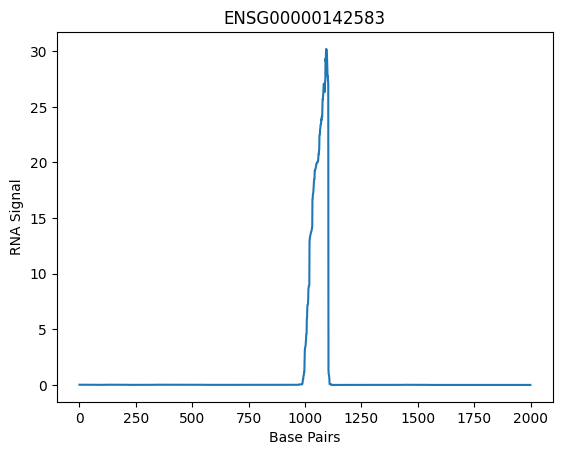

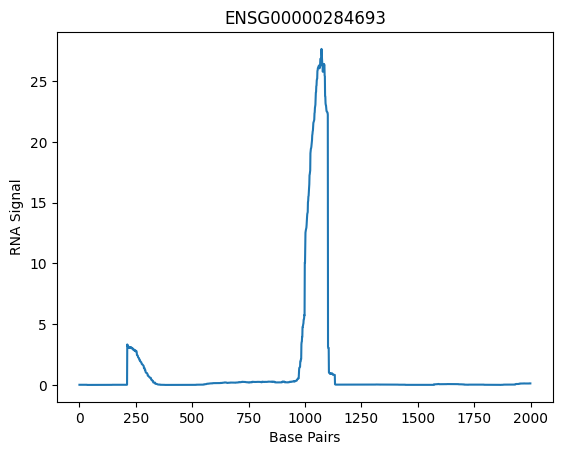

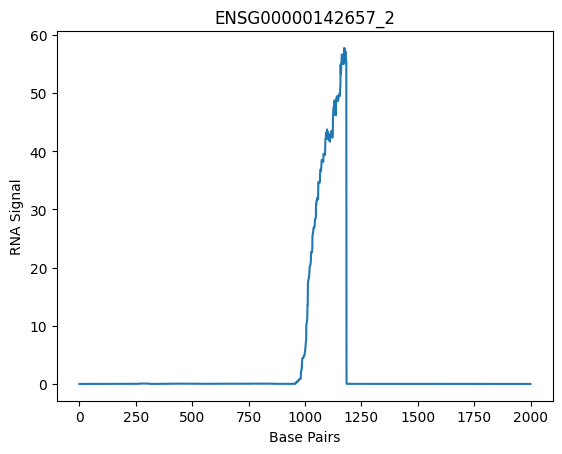

Threshold: 4.5
Number of Genes w/ Strong Peaks: 100


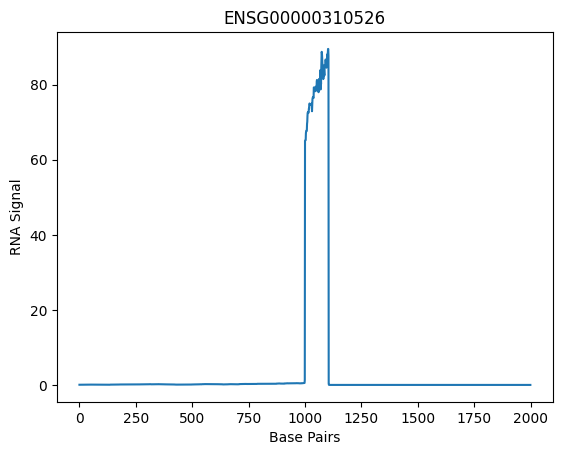

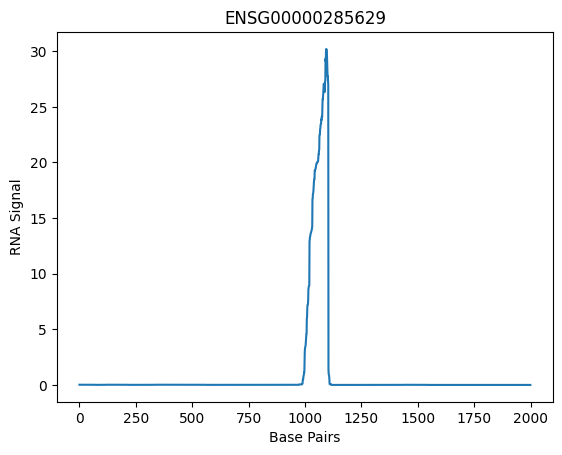

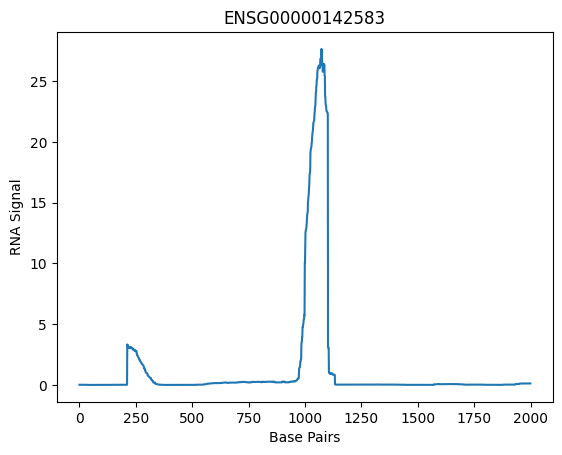

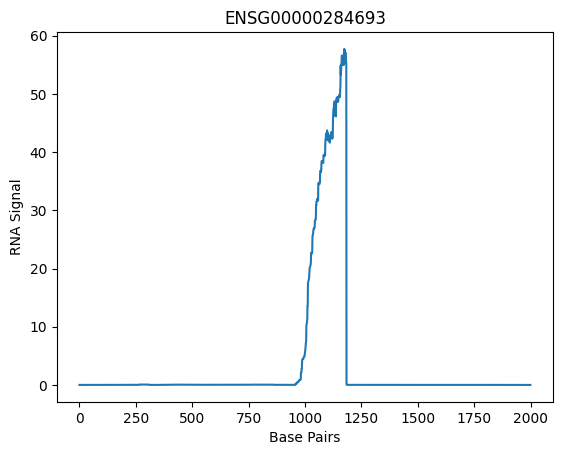

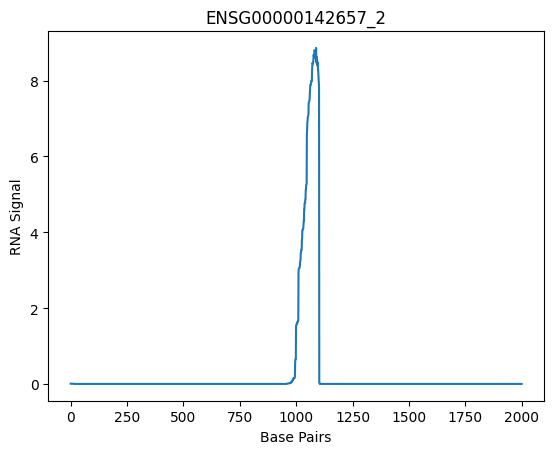

Threshold: 5.0
Number of Genes w/ Strong Peaks: 95


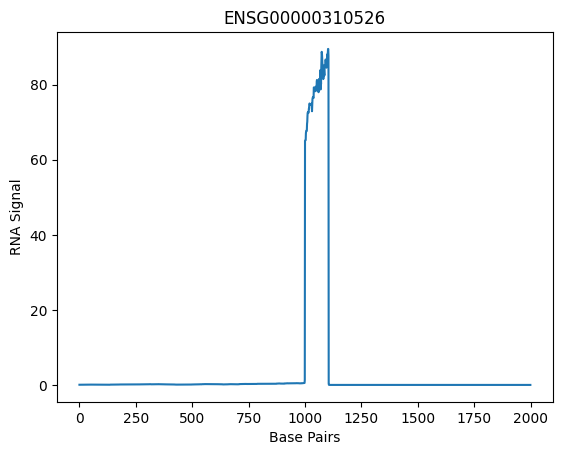

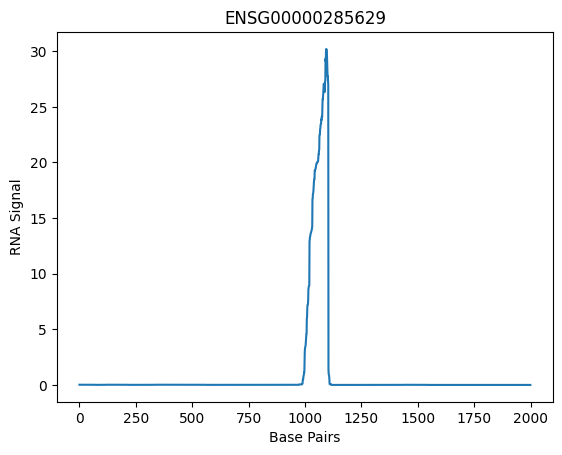

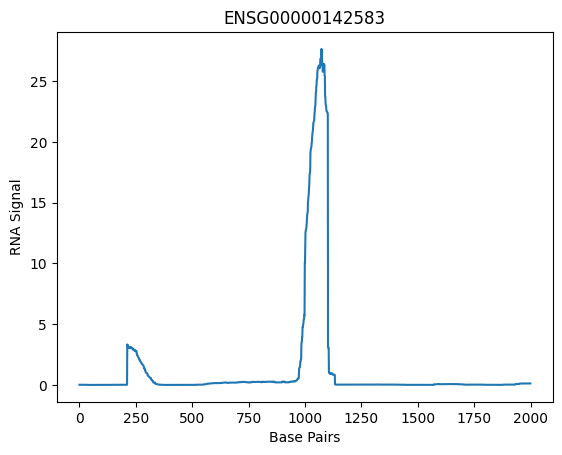

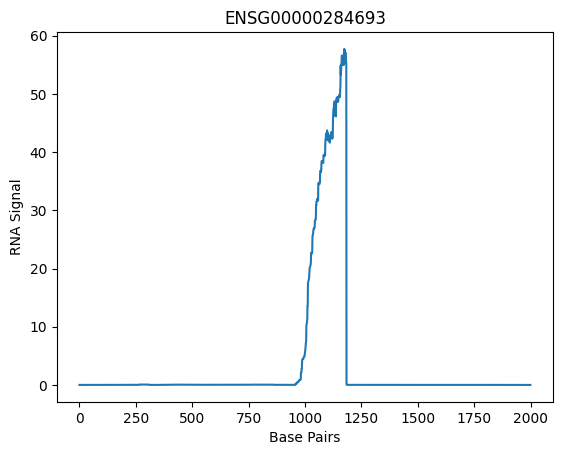

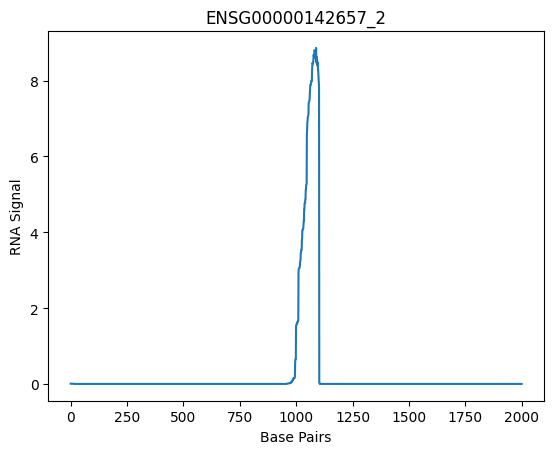

In [81]:
# GM12878
thresholds = np.linspace(0, 5, 11)
bool_df = [gene.decode() in list(fp_gm["ENSID"]) for gene in gm_h5["ensid"]]
rna = gm_h5["rna"][:][bool_df]
ensid = gm_h5["ensid"][:][bool_df]

peak_counts = []
for threshold in thresholds:
    peak = [ensid[idx].decode() for idx, sig in enumerate(rna) if np.max(sig) in sig[808:1192] and np.max(sig) > threshold]
    peak_bool = [gene.decode() in peak for gene in gm_h5["ensid"]]

    peak_counts.append(sum(peak_bool))
    print(f"Threshold: {threshold}\nNumber of Genes w/ Strong Peaks: {sum(peak_bool)}")
    for idx, gene in enumerate(gm_h5["rna"][:][peak_bool][0:5]):
        plt.title(ensid[idx].decode())
        plt.ylabel("RNA Signal")
        plt.xlabel("Base Pairs")
        plt.plot(gene)
        plt.show()

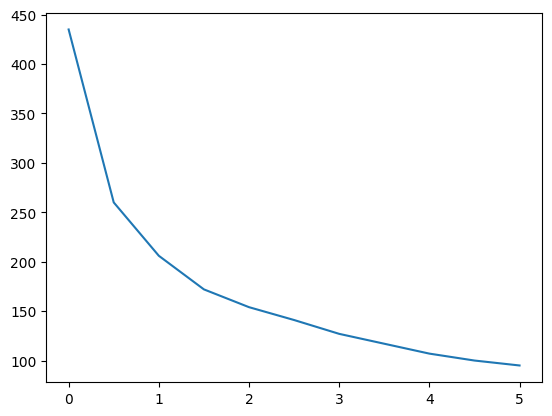

In [82]:
# GM12878
plt.plot(thresholds, peak_counts)

Threshold: 0.0
Number of Genes w/ Strong Peaks: 505


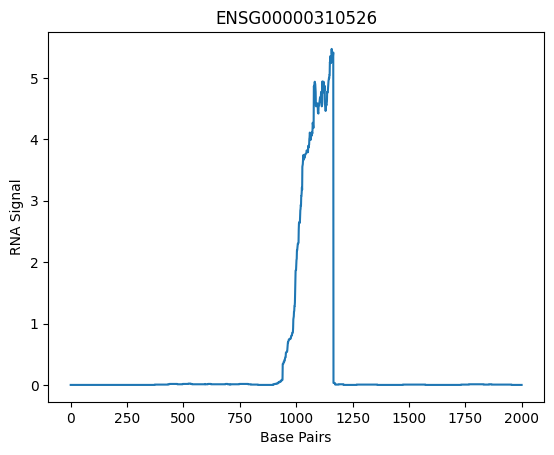

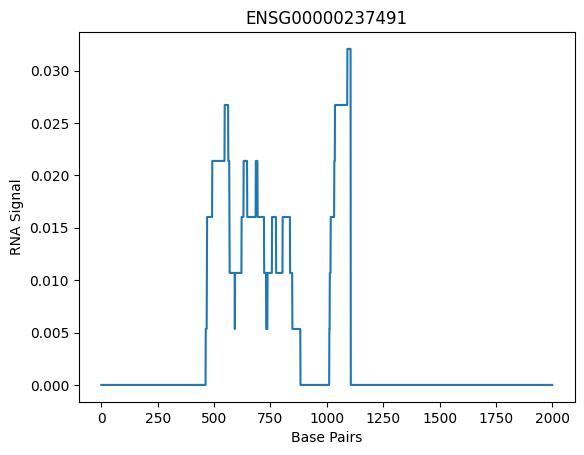

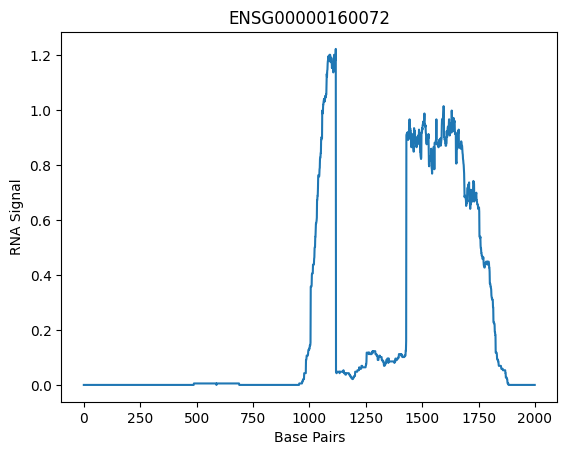

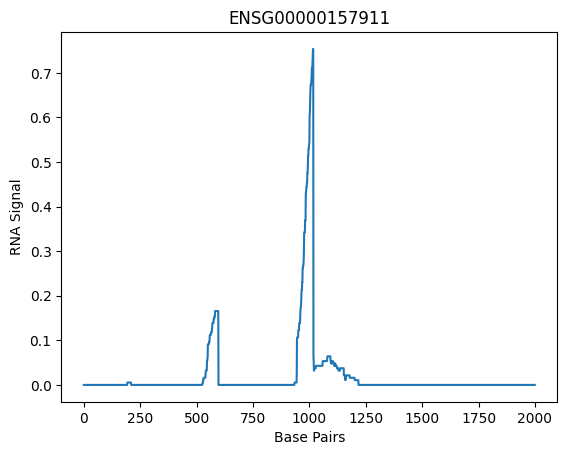

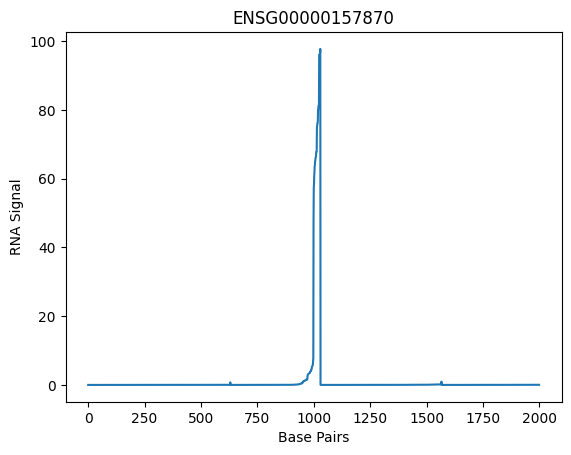

Threshold: 0.5
Number of Genes w/ Strong Peaks: 354


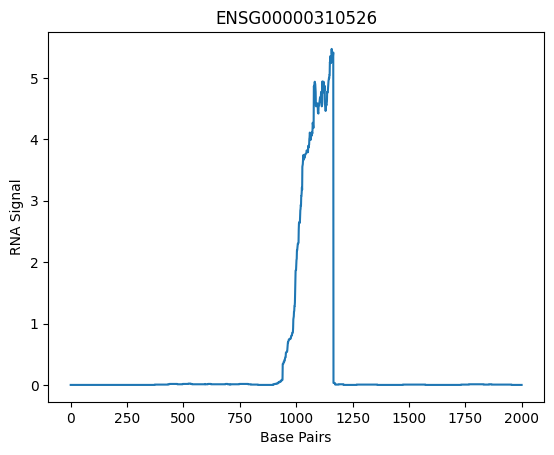

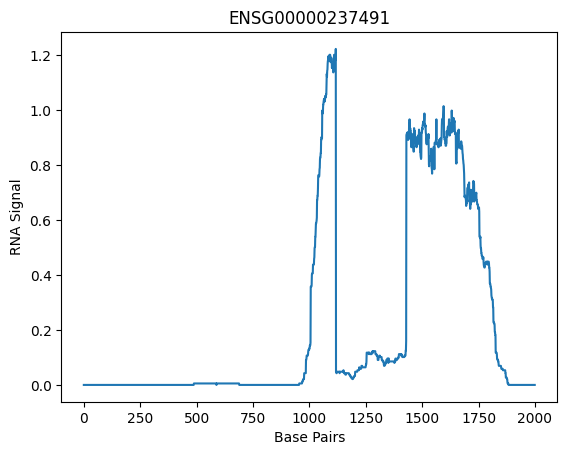

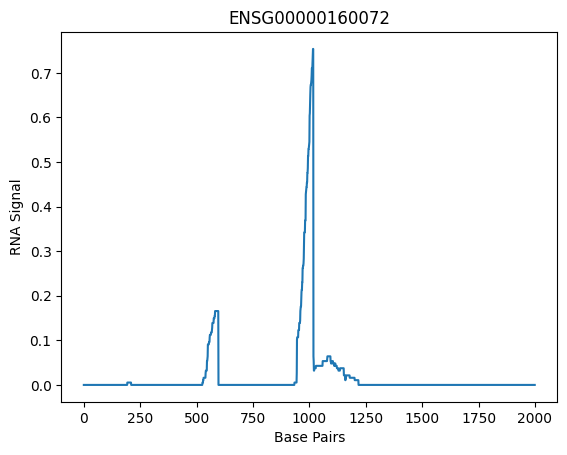

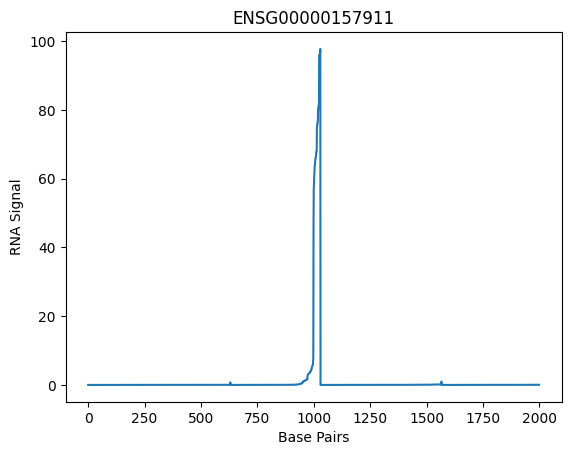

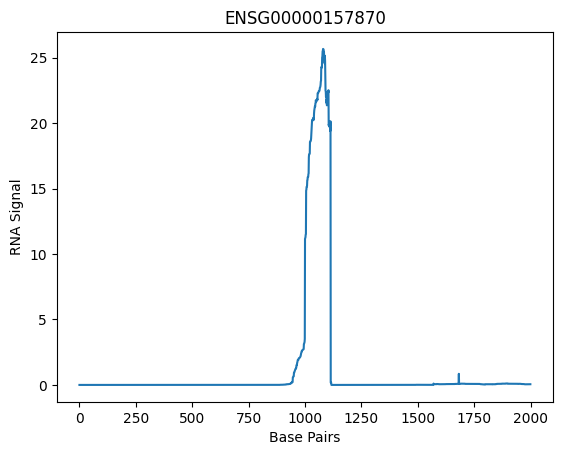

Threshold: 1.0
Number of Genes w/ Strong Peaks: 295


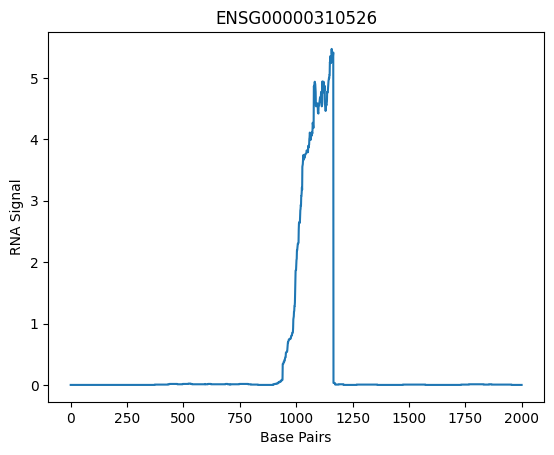

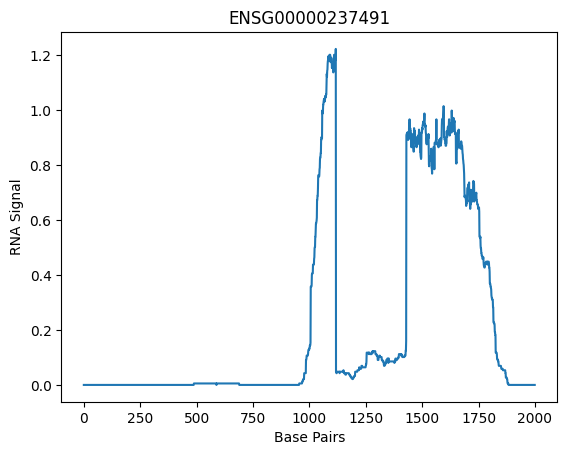

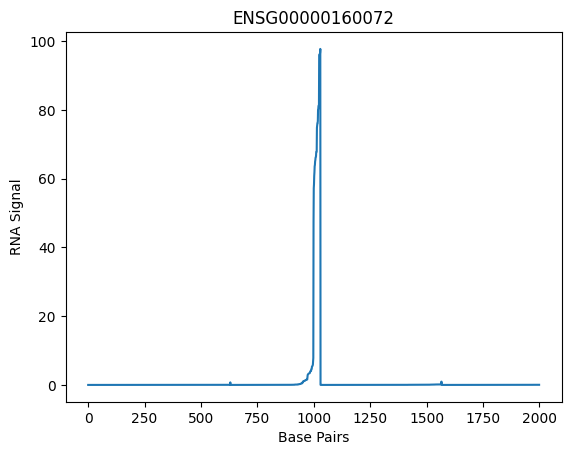

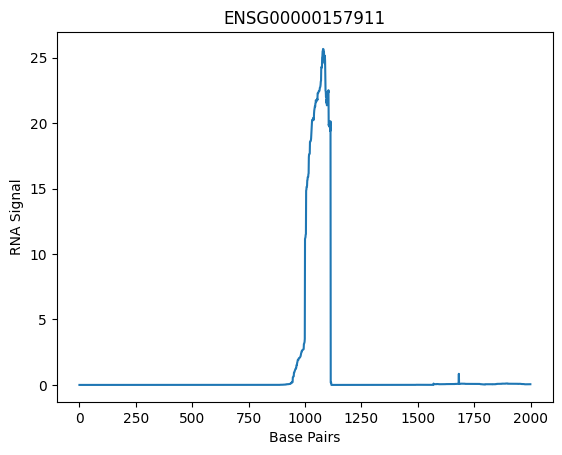

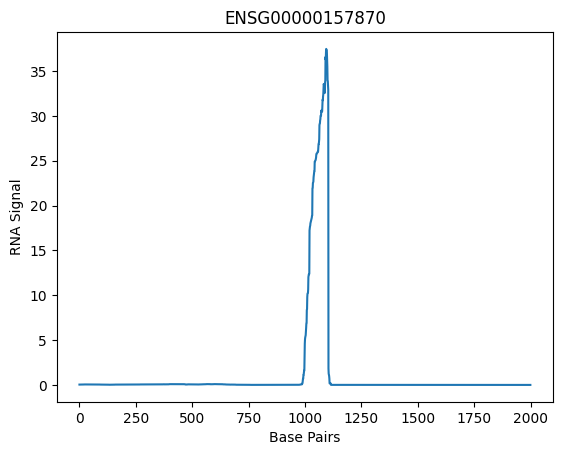

Threshold: 1.5
Number of Genes w/ Strong Peaks: 261


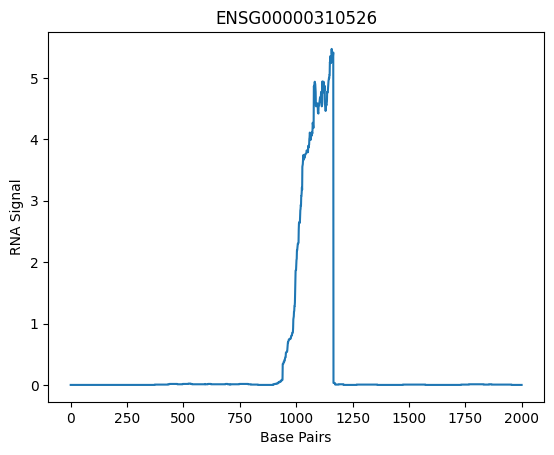

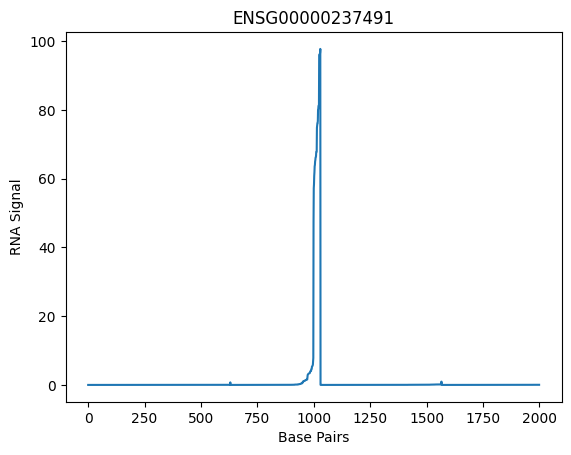

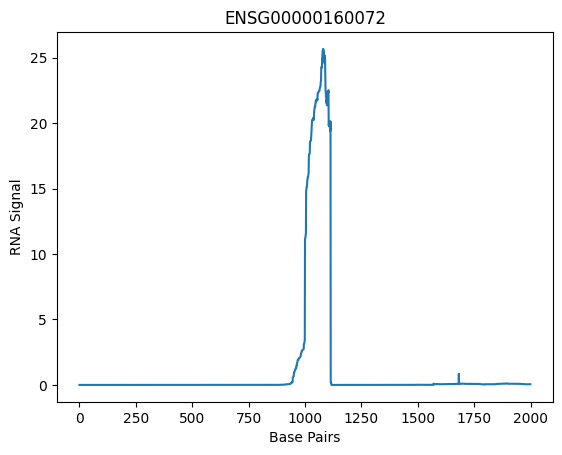

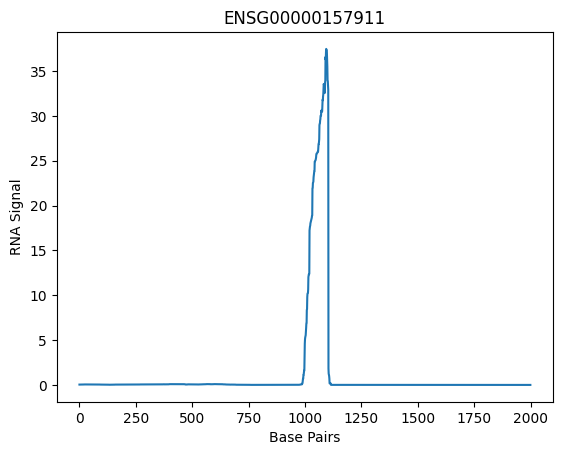

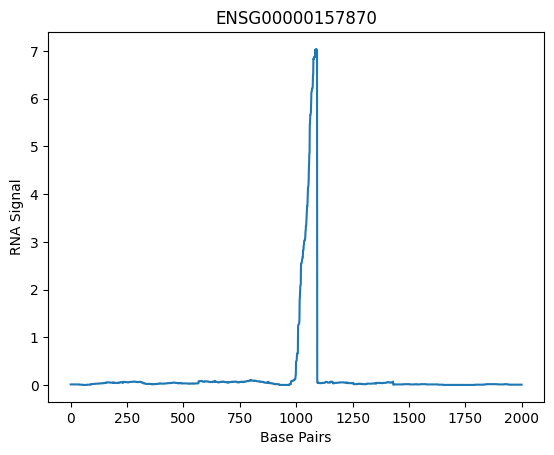

Threshold: 2.0
Number of Genes w/ Strong Peaks: 229


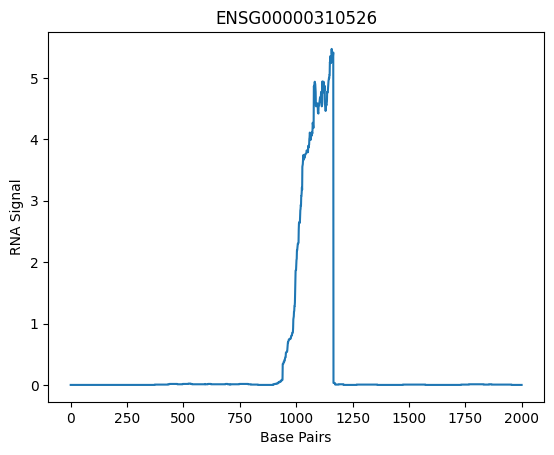

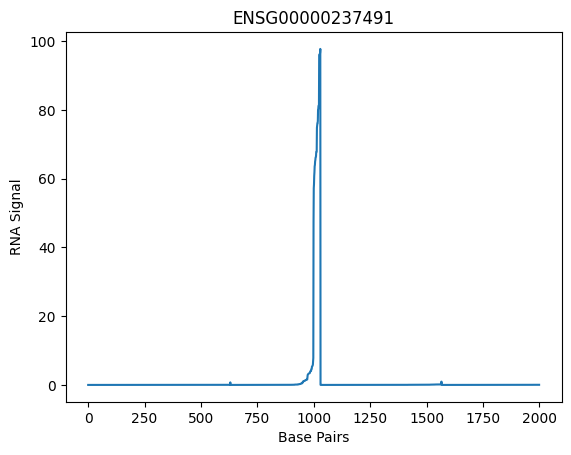

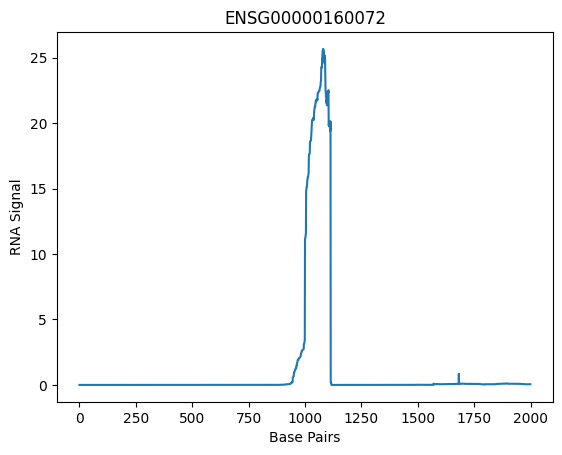

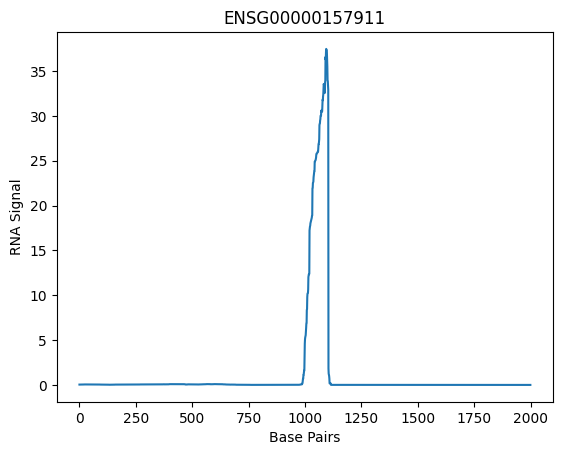

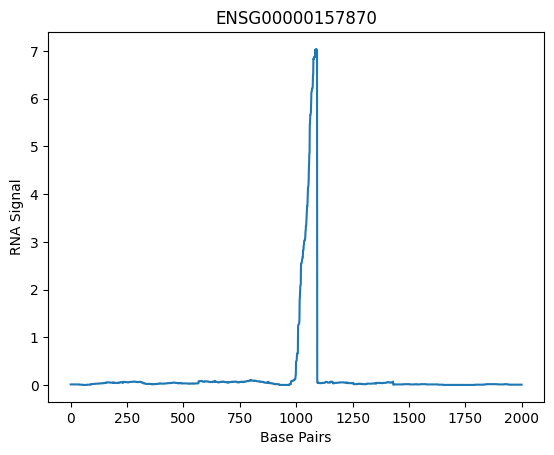

Threshold: 2.5
Number of Genes w/ Strong Peaks: 203


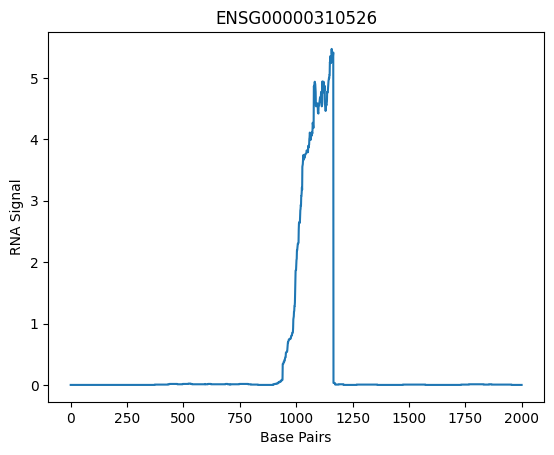

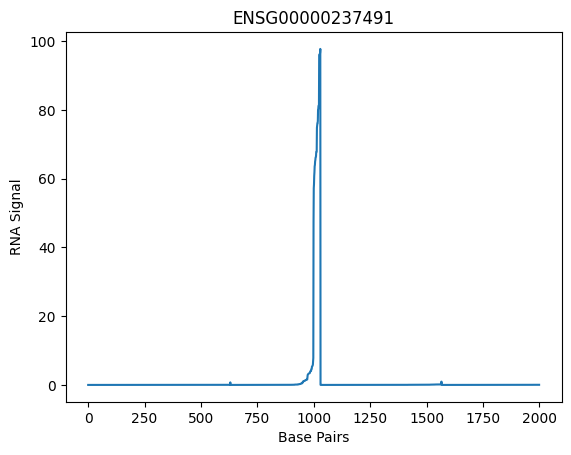

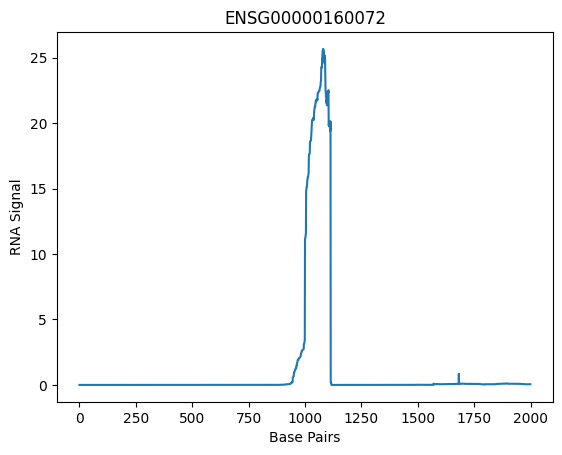

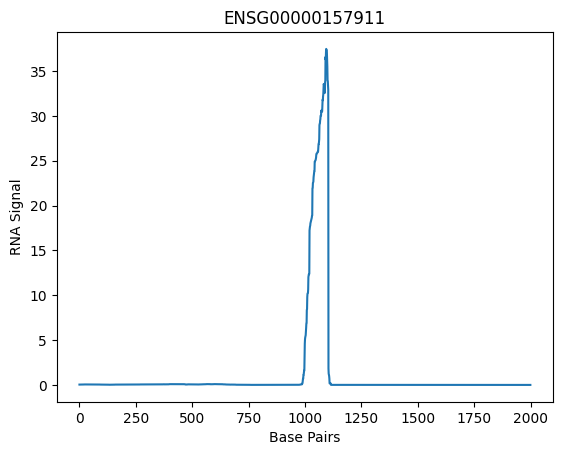

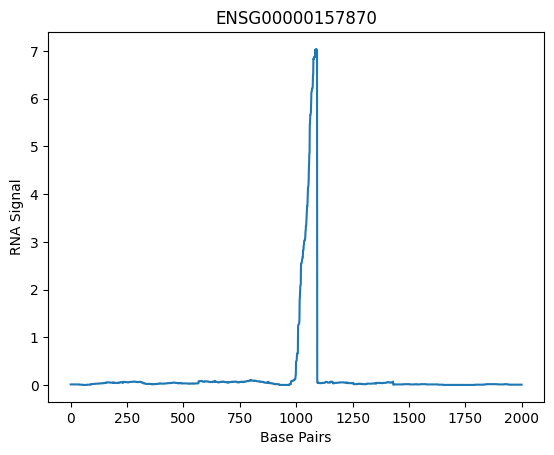

Threshold: 3.0
Number of Genes w/ Strong Peaks: 194


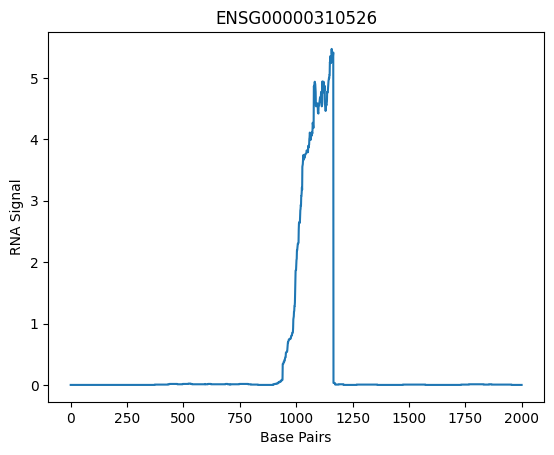

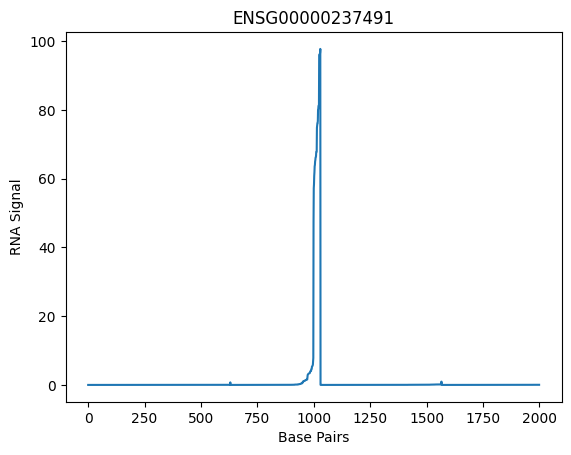

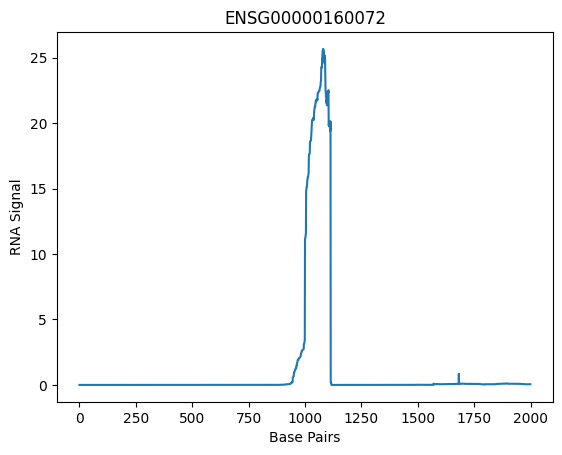

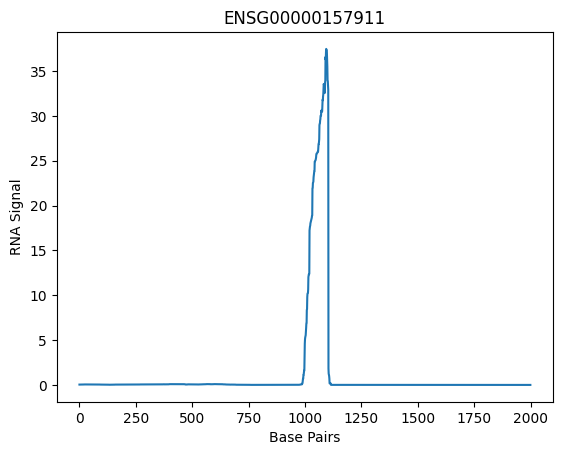

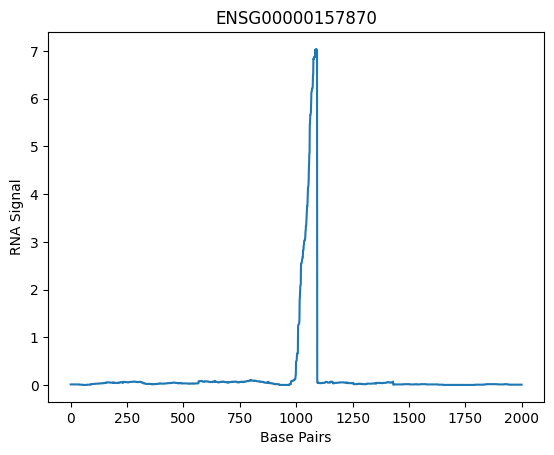

Threshold: 3.5
Number of Genes w/ Strong Peaks: 178


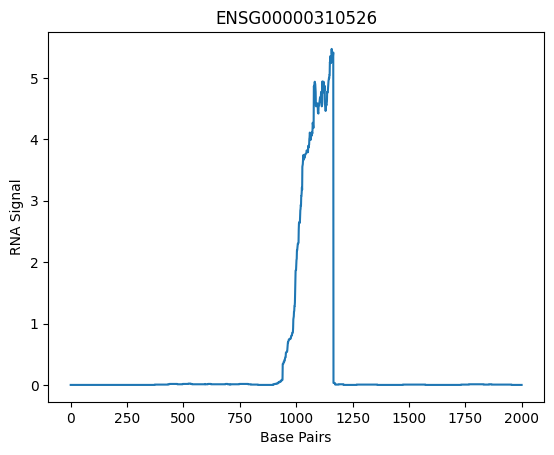

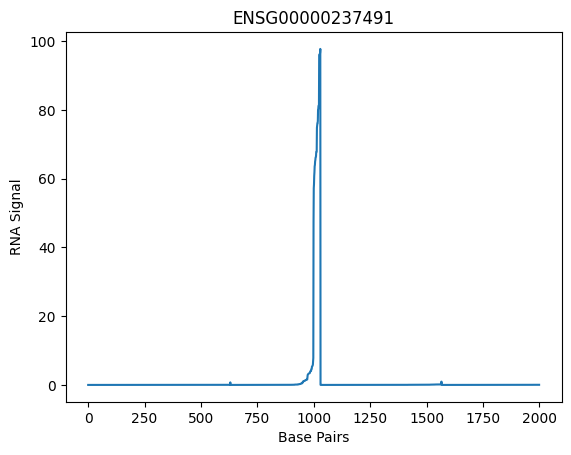

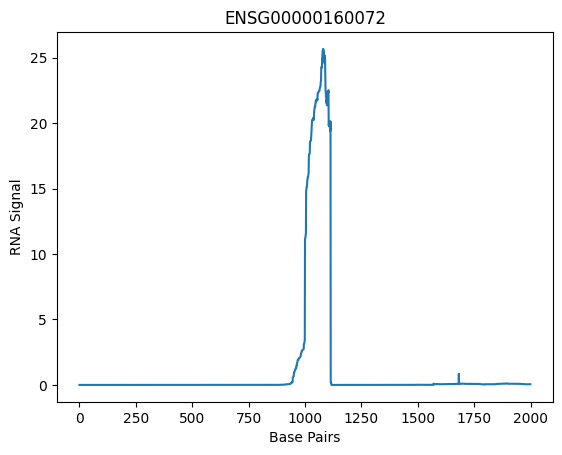

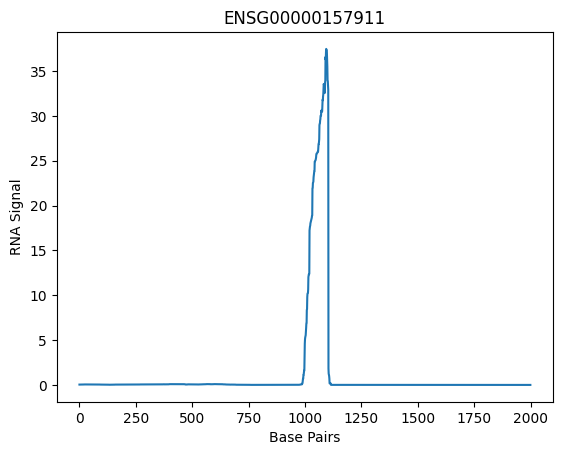

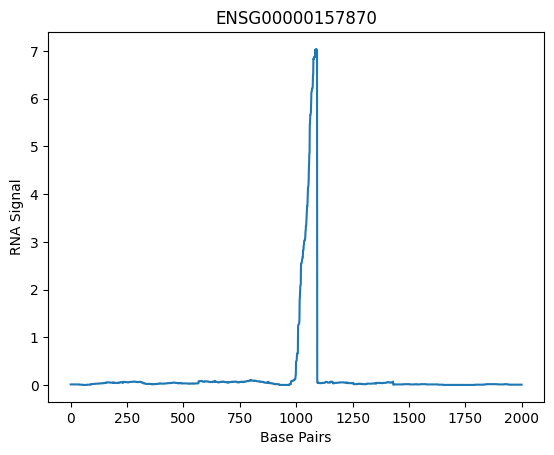

Threshold: 4.0
Number of Genes w/ Strong Peaks: 172


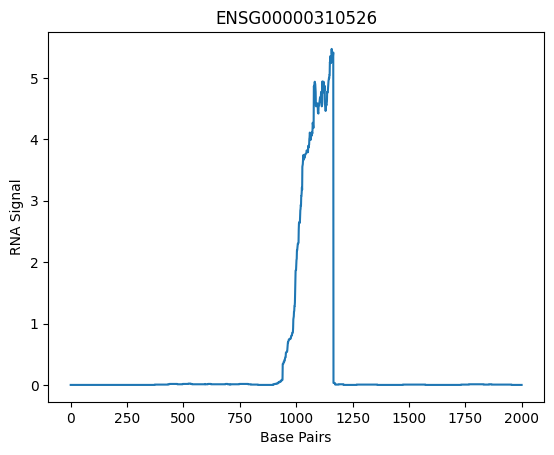

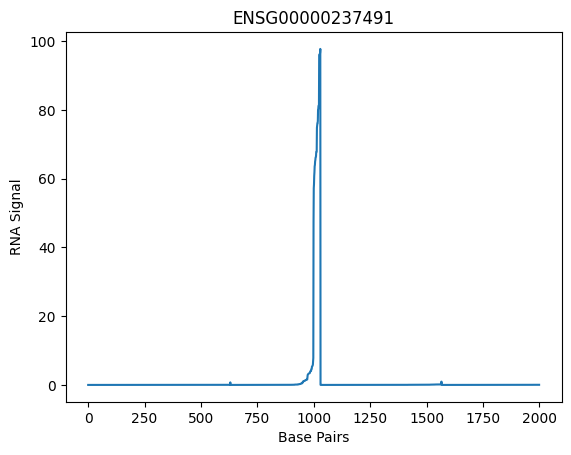

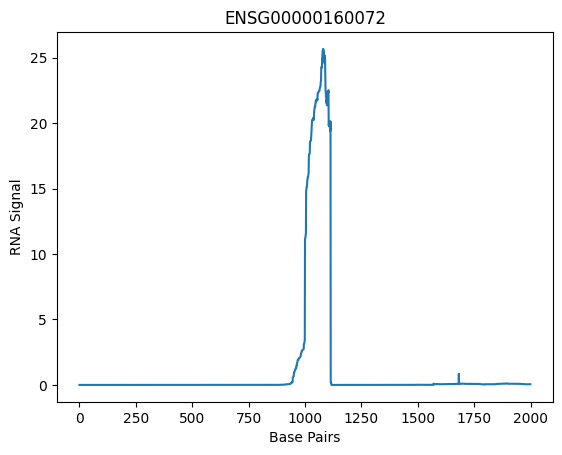

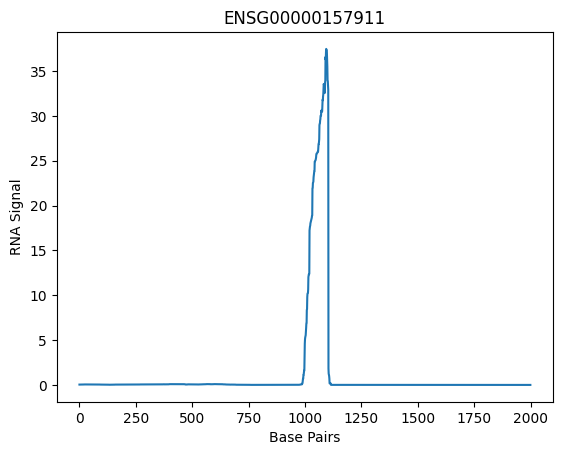

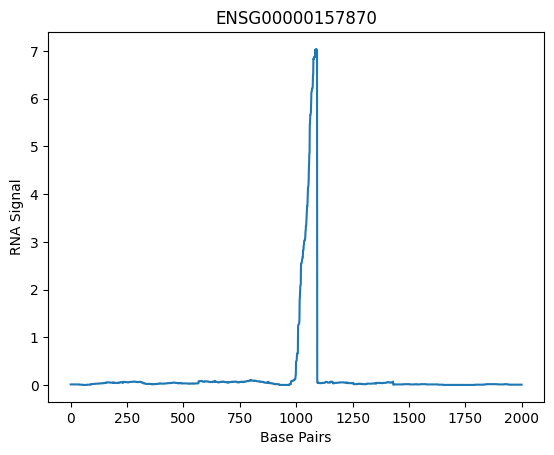

Threshold: 4.5
Number of Genes w/ Strong Peaks: 164


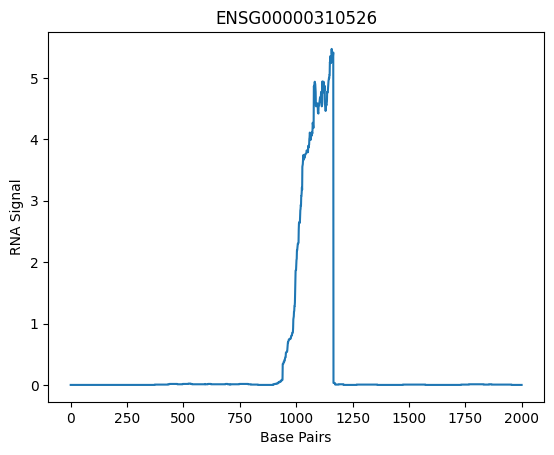

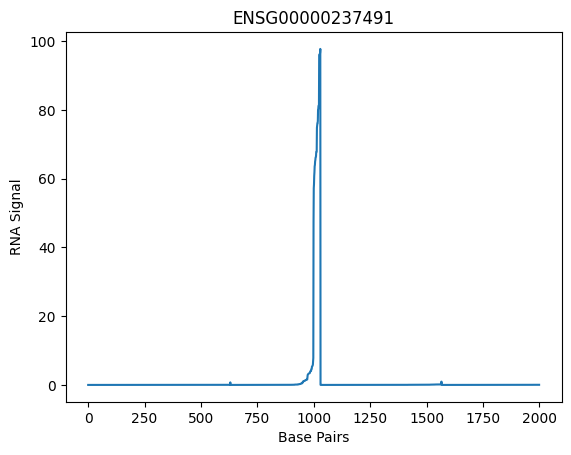

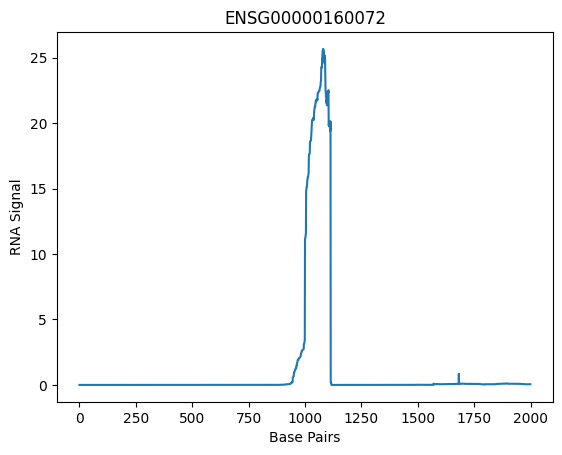

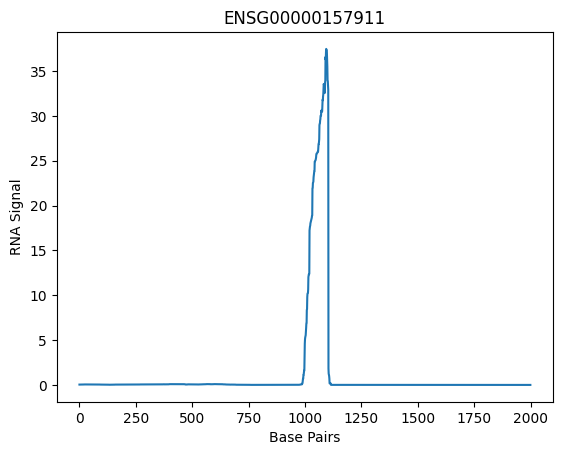

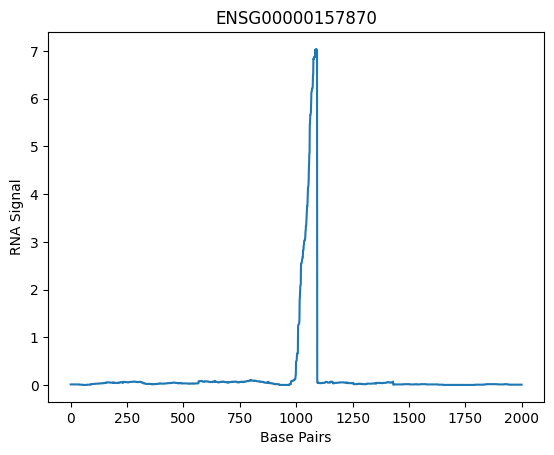

Threshold: 5.0
Number of Genes w/ Strong Peaks: 153


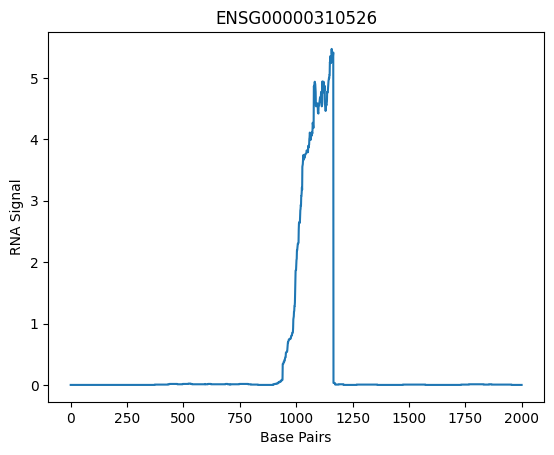

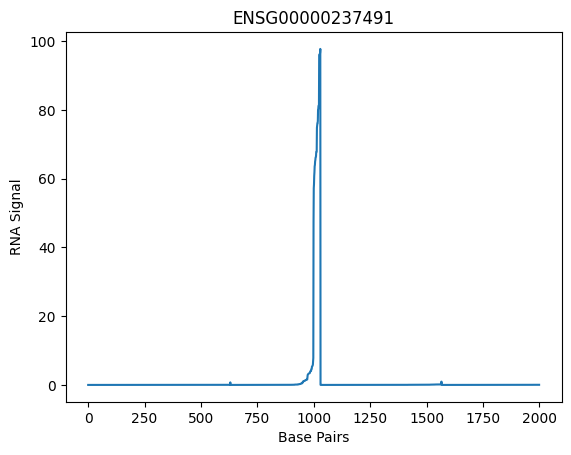

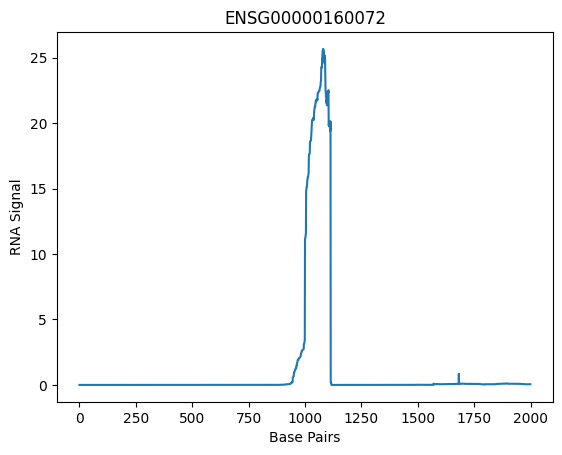

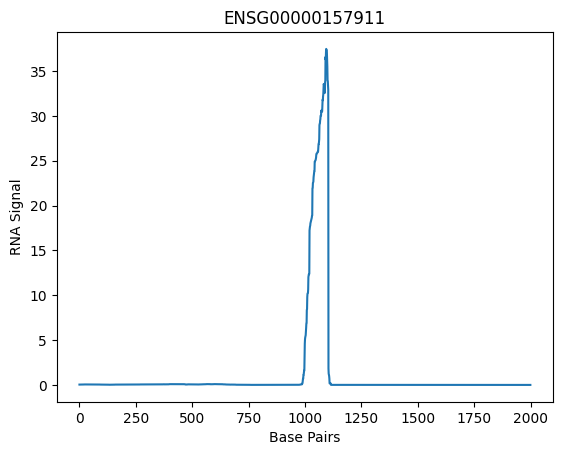

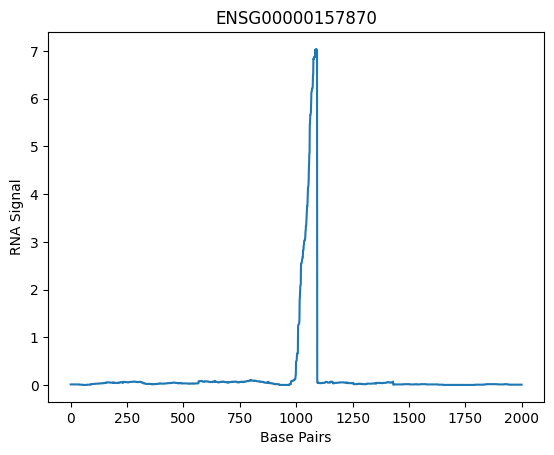

In [83]:
# K562
thresholds = np.linspace(0, 5, 11)
bool_df = [gene.decode() in list(fp_k5["ENSID"]) for gene in k5_h5["ensid"]]
rna = k5_h5["rna"][:][bool_df]
ensid = k5_h5["ensid"][:][bool_df]

peak_counts = []
for threshold in thresholds:
    peak = [ensid[idx].decode() for idx, sig in enumerate(rna) if np.max(sig) in sig[808:1192] and np.max(sig) > threshold]
    peak_bool = [gene.decode() in peak for gene in k5_h5["ensid"]]

    peak_counts.append(sum(peak_bool))
    print(f"Threshold: {threshold}\nNumber of Genes w/ Strong Peaks: {sum(peak_bool)}")
    for idx, gene in enumerate(k5_h5["rna"][:][peak_bool][0:5]):
        plt.title(ensid[idx].decode())
        plt.ylabel("RNA Signal")
        plt.xlabel("Base Pairs")
        plt.plot(gene)
        plt.show()

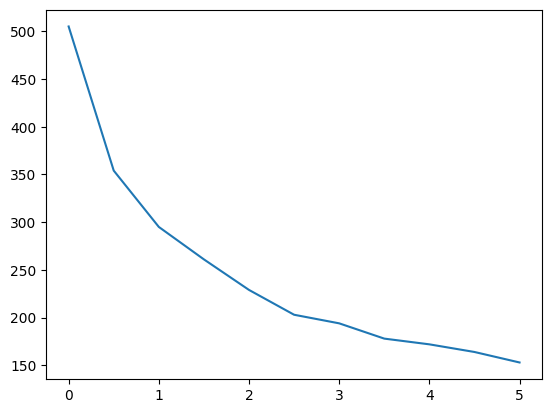

In [84]:
plt.plot(thresholds, peak_counts)

Aggregate Plots of Best Predictions

Threshold: 0.02, with 766 genes.


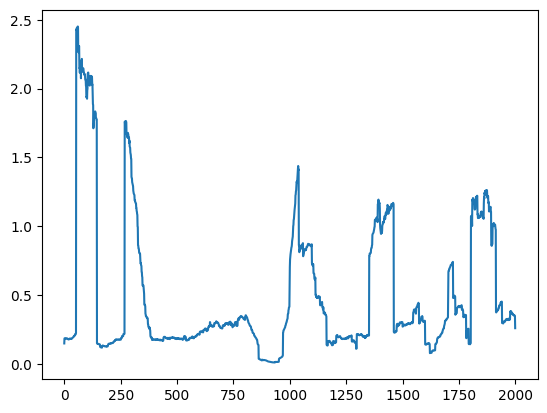

Threshold: 0.039999999999999994, with 1571 genes.


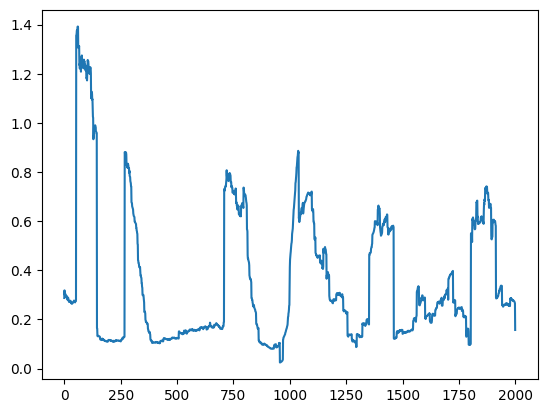

Threshold: 0.06, with 2372 genes.


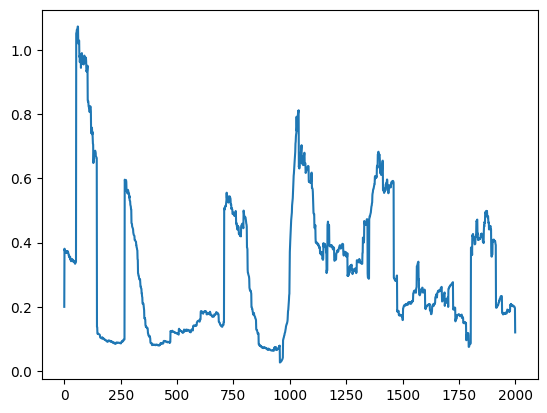

Threshold: 0.07999999999999999, with 3306 genes.


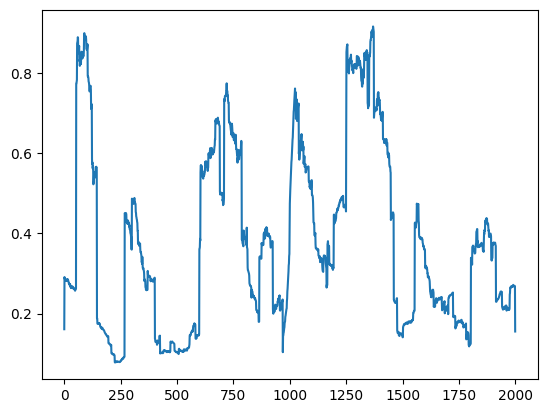

Threshold: 0.09999999999999999, with 4439 genes.


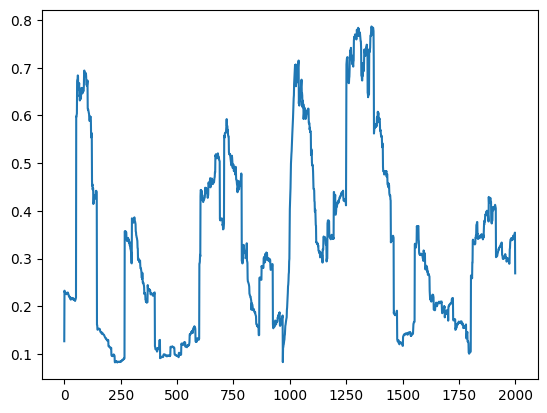

Threshold: 0.11999999999999998, with 5657 genes.


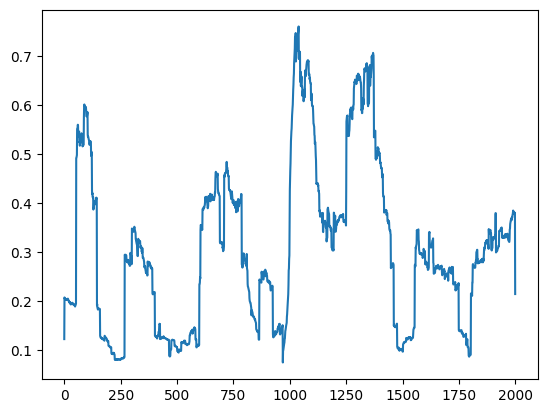

Threshold: 0.13999999999999999, with 6907 genes.


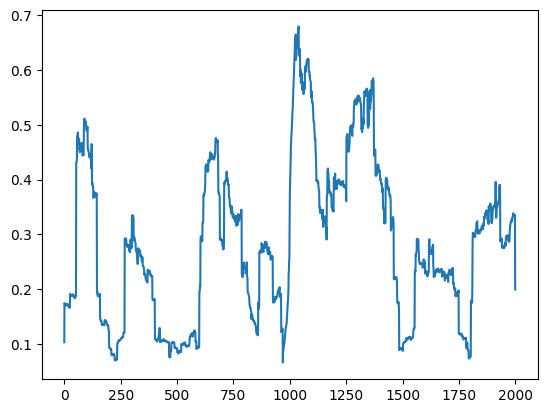

Threshold: 0.15999999999999998, with 8075 genes.


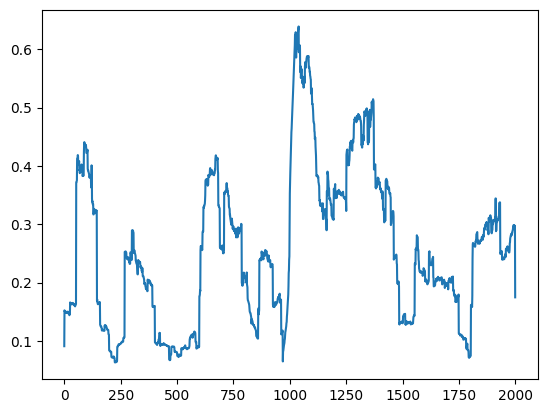

Threshold: 0.17999999999999997, with 9181 genes.


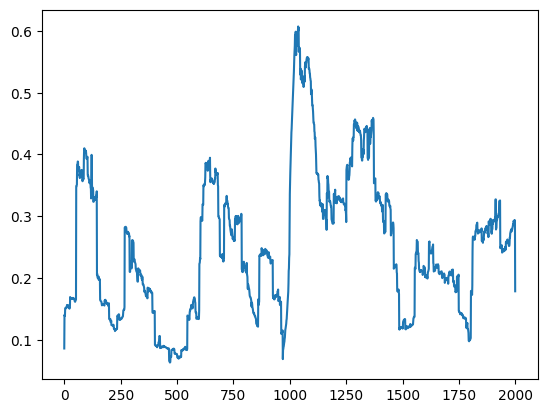

Threshold: 0.19999999999999996, with 10142 genes.


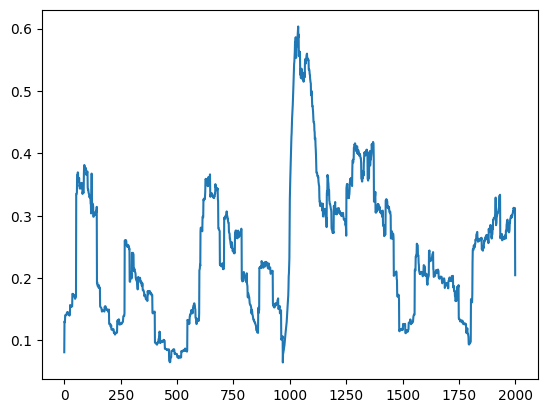

Threshold: 0.21999999999999995, with 11056 genes.


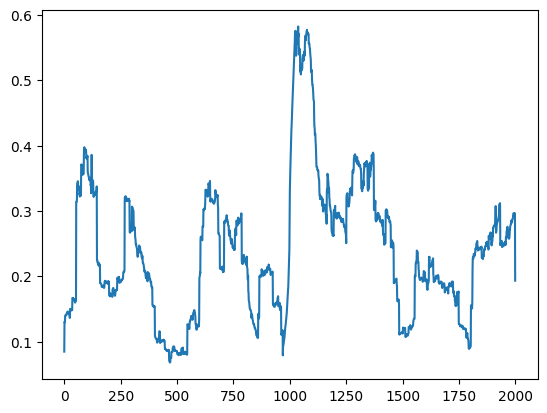

Threshold: 0.23999999999999996, with 11933 genes.


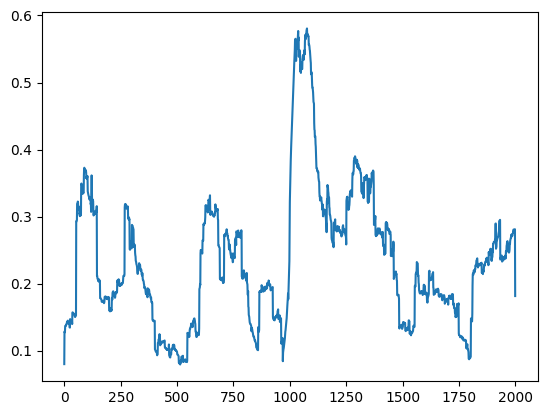

Threshold: 0.25999999999999995, with 12749 genes.


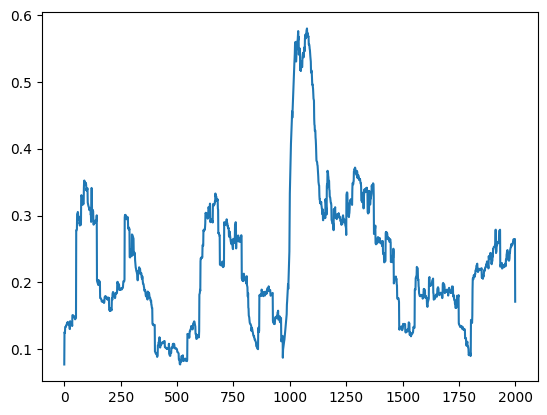

Threshold: 0.27999999999999997, with 13518 genes.


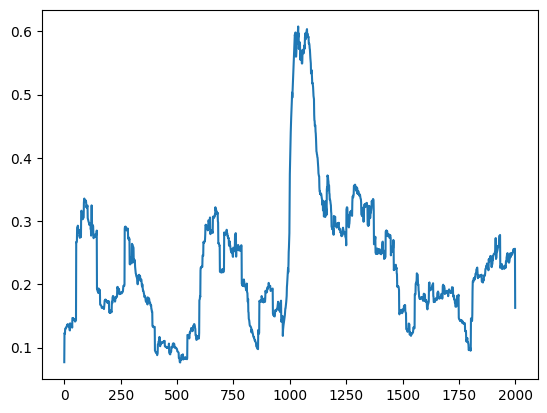

Threshold: 0.3, with 14307 genes.


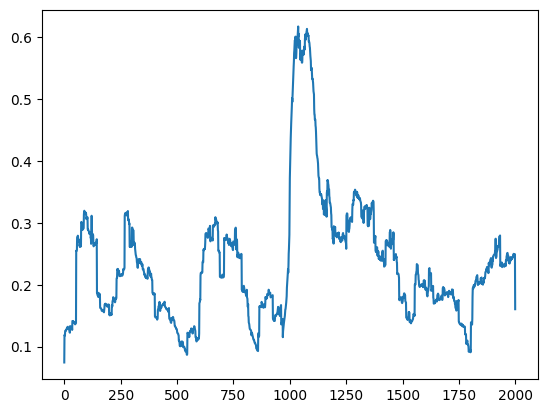

In [85]:
# GM12878
counts = []
thresholds = np.linspace(0.02, 0.3, 15)
for threshold in thresholds:
    best_gm = gm[gm["Error"] < threshold]

    bool_df = [gene.decode() in list(best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]
    ensid = gm_h5["ensid"][:][bool_df]
    rna = gm_h5["rna"][:][bool_df]

    counts.append(len(rna))
    print(f"Threshold: {threshold}, with {len(rna)} genes.")
    plt.plot(np.mean(rna, axis=0))
    plt.show()


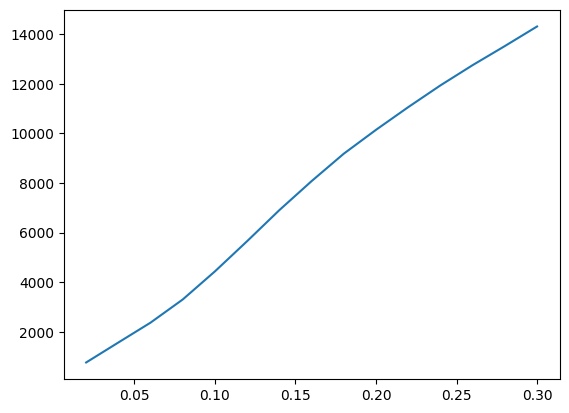

In [86]:
plt.plot(thresholds, counts)

Threshold: 0.01, with 581 genes.


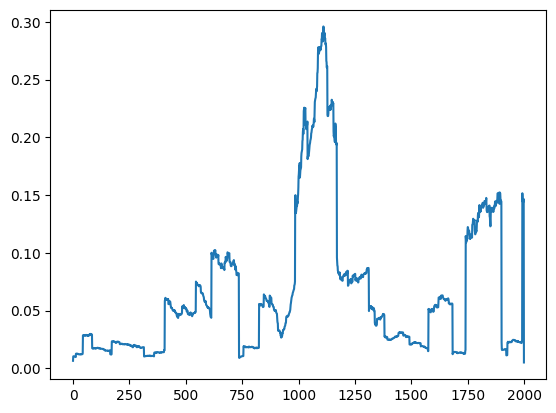

Threshold: 0.02, with 1188 genes.


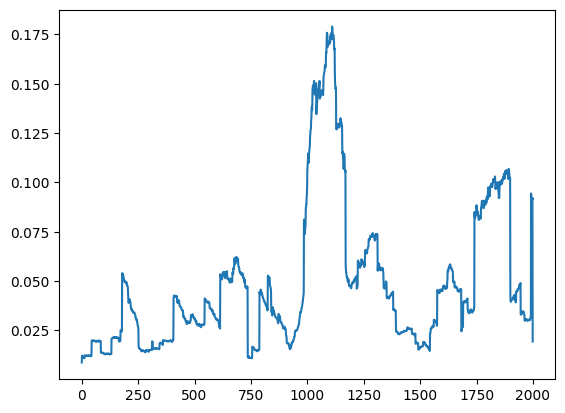

Threshold: 0.03, with 1878 genes.


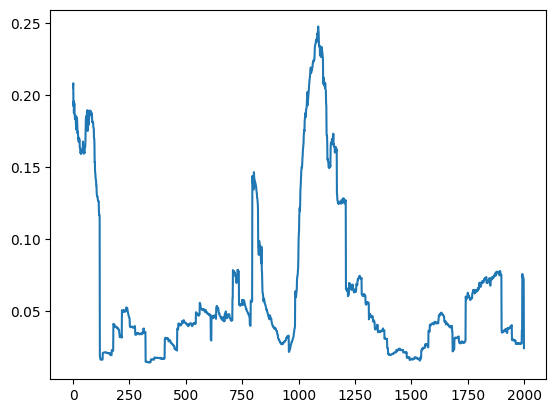

Threshold: 0.04, with 2511 genes.


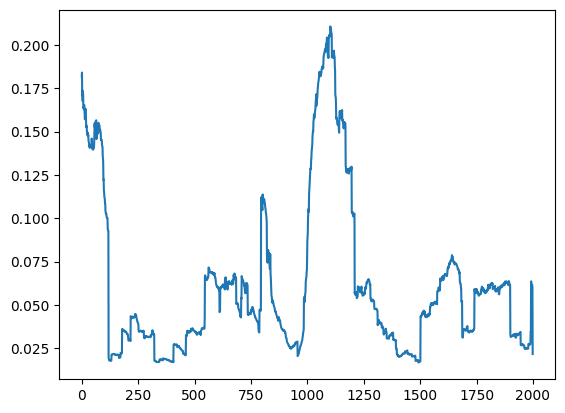

Threshold: 0.05, with 3191 genes.


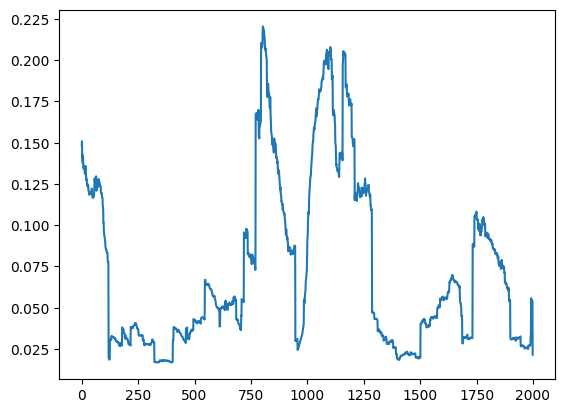

In [87]:
# K562
counts = []
thresholds = np.linspace(0.01, 0.05, 5)
for threshold in thresholds:
    best_k5 = k5[k5["Error"] < threshold]

    bool_df = [gene.decode() in list(best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]
    ensid = k5_h5["ensid"][:][bool_df]
    rna = k5_h5["rna"][:][bool_df]

    print(f"Threshold: {threshold}, with {len(rna)} genes.")
    counts.append(len(rna))
    plt.plot(np.mean(rna, axis=0))
    plt.show()

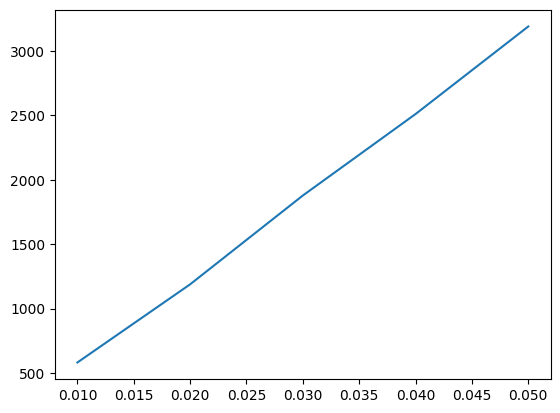

In [88]:
plt.plot(thresholds, counts)

List of Genes for K562 (Error < 0.01)

In [ ]:
a = gm[gm["Error"] < 0.02]["Unnamed: 0"].to_csv("k562.001.txt", header=False, index=None, sep=" ")

2350    1.201646
Name: Pred, dtype: float64
2350    1.207465
Name: actual, dtype: float64


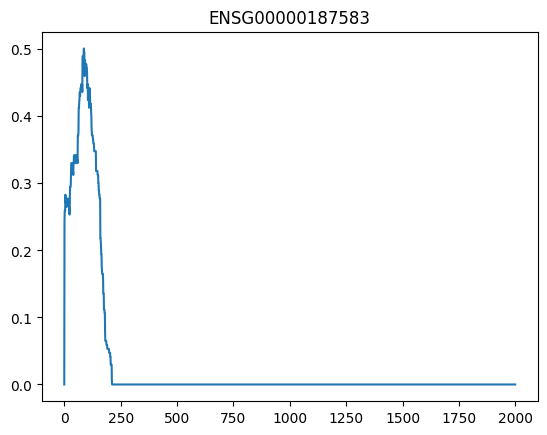

66    2.775368
Name: Pred, dtype: float64
66    2.761314
Name: actual, dtype: float64


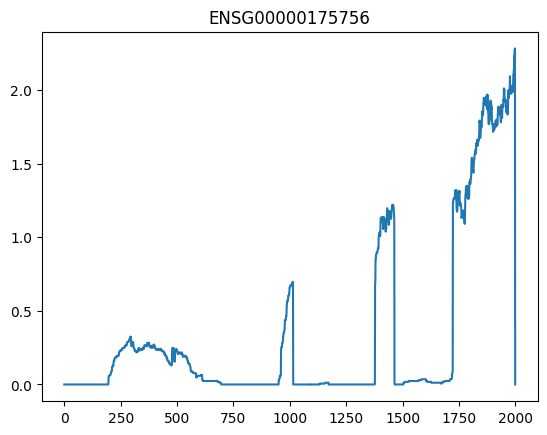

316    1.654435
Name: Pred, dtype: float64
316    1.672126
Name: actual, dtype: float64


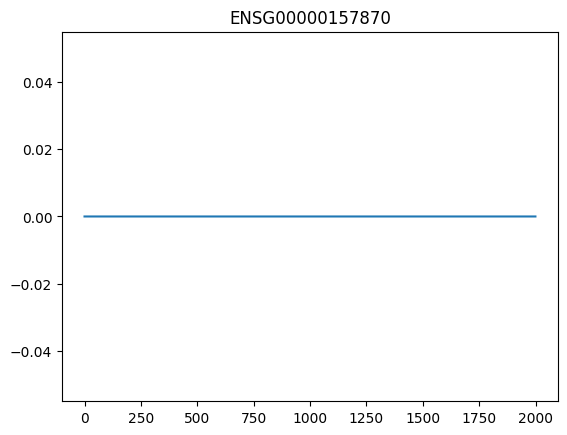

8    1.418638
Name: Pred, dtype: float64
8    1.404526
Name: actual, dtype: float64


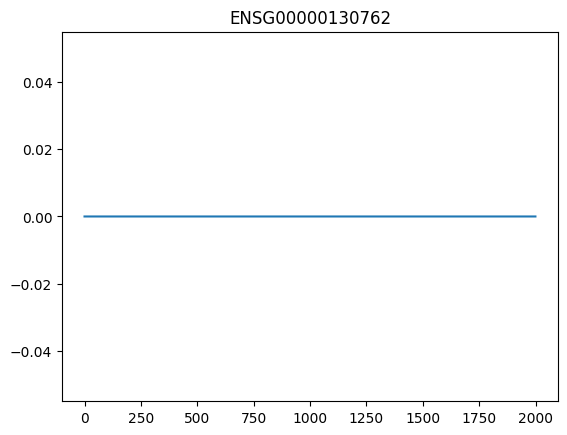

897    1.068704
Name: Pred, dtype: float64
897    1.075328
Name: actual, dtype: float64


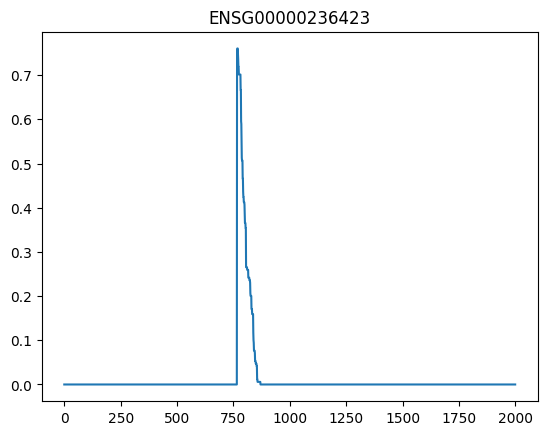

In [107]:
bool_df = [gene.decode() in list(a) for gene in gm_h5["ensid"]]
rna = gm_h5["rna"][:][bool_df]
ensid = gm_h5["ensid"][:][bool_df]

for idx, sig in enumerate(rna[0:5]):
    plt.plot(sig)
    plt.title(ensid[idx].decode())
    print(gm[gm["Unnamed: 0"] == ensid[idx].decode()]["Pred"])
    print(gm[gm["Unnamed: 0"] == ensid[idx].decode()]["actual"])
    plt.show()

List of Genes for K562 (Set Difference Between Error < 0.03 and Error < 0.04)

In [90]:
# k5_003 = k5[k5["Error"] < 0.03]["Unnamed: 0"]
# k5_004 = k5[k5["Error"] < 0.04]["Unnamed: 0"]

In [91]:
# diff_003_004 = k5_004[~k5_004.isin(k5_003)]
# k5_004[~k5_004.isin(k5_003)].to_csv("k562.003_004_diff.txt", header=False, index=None, sep=" ")

Identify Outliers in the Set Difference

In [92]:
# bool_df = [gene.decode() in list(diff_003_004) for gene in k5_h5["ensid"]]
# rna = k5_h5["rna"][:][bool_df]
# ensid = k5_h5["ensid"][:][bool_df]

In [93]:
# with open("k5_003_004_outliers.txt", "a") as file:
#     for idx, sig in enumerate(rna):
#         if np.max(sig) > 1 and np.max(sig) in sig[450:900]:
#             file.write(f"{ensid[idx].decode()}\n")

        

Examining ENSG00000175756

In [111]:
enhancer_gene_gm12878_100kb = pd.read_csv('data/GM12878_enhancer_gene_links_100kb.hg38.tsv', sep='\t')
gene_gm12878_tss = pd.read_csv('data/ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt', sep='\t')[['name', 'Ensembl_ID', 'chr', 'tss', 'strand', 'H3K27ac.RPM.TSS1Kb', 'DHS.RPM.TSS1Kb']]
gene_gm12878_tss['ENSID'] = gene_gm12878_tss['Ensembl_ID']

enhancer_gene_gm12878_100kb_includeNoEnhancerGene = enhancer_gene_gm12878_100kb.merge(gene_gm12878_tss, left_on='TargetGeneEnsembl_ID', right_on='Ensembl_ID', how='right', suffixes=['', '_gene']).reset_index()

In [113]:
gene = "ENSG00000175756"
num_TSS = !grep {gene} data/RNA_CAGE.txt | wc -l
num_TSS = int(num_TSS[0])
gene_list = [f"{gene}_{x}" if x > 0 else gene for x in range(num_TSS)]